<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

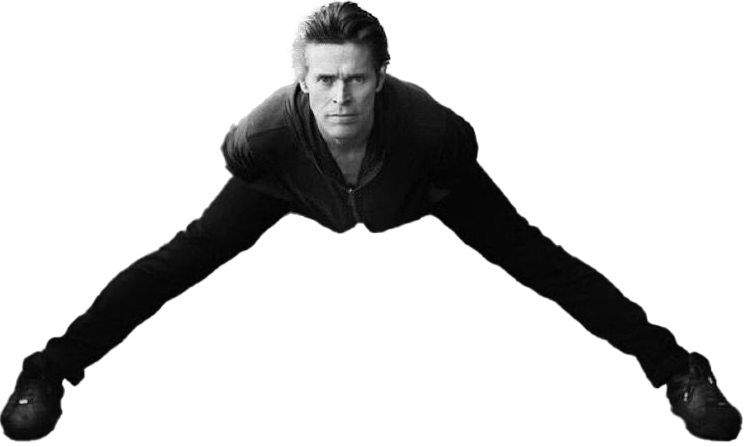

#TODO:

<br>

###Top Priority

---


####Finish classifier code
####Summary statistics such as RMSE, MAE, f1-score, sensitivity, specificity, etc.
####Make a loadings plot for linear regression
####Cross-validation with both test-set and k-fold cross-validation


---

<br>

###Second Priority

---


####Cast data_year columns to int
####Figure out why ethnicity_race_cols are converted to np.nan instead of float values
####Stop dropping other data years from county_demo_df
####Replace Anti-Church of Jesus Christ bias with Anti-Mormon
####Add county demographic data from other years
####Get p-values for in merged_df?

#Import and Config

##Import all libraries

In [1]:
# Basics
import numpy as np
import re
import warnings


# Pandas
import pandas as pd


# Scikit-Learn
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# Classifiers
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB



# Plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

##Config

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
minimum_categorical_positive_count = 5
default_z_threshold_for_outliers = 2.5
# years to draw crime data from
years = [i for i in range(2010, 2020)] + [2021, 2022]

##Import datasets

In [5]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [6]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/hate_crime/hate_crime.csv", on_bad_lines='skip')

In [7]:
# create the county_demo_df
county_demo_df = pd.DataFrame()

# combine all datasets of the specified years
for year in years:
  temp_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/data/ACSDP1Y" + str(year) + ".DP05-Data.csv", on_bad_lines='skip')

  #fix the headers
  temp_df = fixHeaders(temp_df)
  temp_df["data_year"] = year

  print("Imported " + str(year))

  if county_demo_df.empty:
    county_demo_df = temp_df
  else:
    # drop all column duplicates
    county_demo_df = county_demo_df.loc[:,~county_demo_df.columns.duplicated()].copy()
    temp_df = temp_df.loc[:,~temp_df.columns.duplicated()].copy()

    cols_to_merge_on = list(set(temp_df.columns).intersection(set(county_demo_df.columns)))
    county_demo_df = pd.merge(county_demo_df, temp_df, how="outer")

Imported 2010
Imported 2011
Imported 2012
Imported 2013
Imported 2014
Imported 2015
Imported 2016
Imported 2017
Imported 2018
Imported 2019
Imported 2021
Imported 2022


In [8]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

In [9]:
county_demo_df.head()

0       Geography     Geographic Area Name  \
0  0500000US01003  Baldwin County, Alabama   
1  0500000US01015  Calhoun County, Alabama   
2  0500000US01043  Cullman County, Alabama   
3  0500000US01049   DeKalb County, Alabama   
4  0500000US01051   Elmore County, Alabama   

0 Estimate!!SEX AND AGE!!Total population  \
0                                  183195   
1                                  118510   
2                                   80459   
3                                   71151   
4                                   79549   

0 Estimate Margin of Error!!SEX AND AGE!!Total population  \
0                                              *****        
1                                              *****        
2                                              *****        
3                                              *****        
4                                              *****        

0 Percent!!SEX AND AGE!!Total population  \
0                                 183195   
1                                 118510   
2                                  80459   
3                                  71151   
4                                  79549   

0 Percent Margin of Error!!SEX AND AGE!!Total population  \
0                                                (X)       
1                                                (X)       
2                                                (X)       
3                                                (X)       
4                                                (X)       

0 Estimate!!SEX AND AGE!!Male Estimate Margin of Error!!SEX AND AGE!!Male  \
0                       89930                                        1065   
1                       56454                                         533   
2                       40063                                         495   
3                       35647                                         785   
4                       39089                                         538   

0 Percent!!SEX AND AGE!!Male Percent Margin of Error!!SEX AND AGE!!Male  \
0                       49.1                                        0.6   
1                       47.6                                        0.4   
2                       49.8                                        0.6   
3                       50.1                                        1.1   
4                       49.1                                        0.7   

0 Estimate!!SEX AND AGE!!Female Estimate Margin of Error!!SEX AND AGE!!Female  \
0                         93265                                          1065   
1                         62056                                           533   
2                         40396                                           495   
3                         35504                                           785   
4                         40460                                           538   

0 Percent!!SEX AND AGE!!Female Percent Margin of Error!!SEX AND AGE!!Female  \
0                         50.9                                          0.6   
1                         52.4                                          0.4   
2                         50.2                                          0.6   
3                         49.9                                          1.1   
4                         50.9                                          0.7   

0 Estimate!!SEX AND AGE!!Under 5 years  \
0                                10991   
1                                 7381   
2                                 4817   
3                                 5011   
4                                 4871   

0 Estimate Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                521     
1                                                649     
2                                                381     
3                                                283     
4                                       

#Data Cleaning

In [10]:
#only consider county data from 2002-2022; had to expand scope since sample sizes were unreliably small using only 2022
crime_df = crime_df[(crime_df['data_year'].isin(years)) & ((crime_df['agency_type_name'] == "County"))]

In [11]:
crime_df.reset_index(inplace=True)

##Important Functions

In [12]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        if value in set(df.columns):
          unique_col_counts[value] = df[value].sum()
          # print(value)

    return unique_col_counts

In [13]:
def drop_outliers(df, numerical_cols, z_threshold=default_z_threshold_for_outliers):
    df_out = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for column in numerical_cols:
        # Calculate Z-score for each value in the column
        z_scores = np.abs((df_out[column] - df_out[column].mean()) / df_out[column].std())

        print(z_scores.head())

        # Identify outliers based on Z-score
        outliers = df_out[z_scores > z_threshold]

        # Drop outliers from the DataFrame
        df_out = df_out.drop(outliers.index)

    return df_out

##Clean county demographic dataset

In [14]:
county_demo_df.head()

0       Geography     Geographic Area Name  \
0  0500000US01003  Baldwin County, Alabama   
1  0500000US01015  Calhoun County, Alabama   
2  0500000US01043  Cullman County, Alabama   
3  0500000US01049   DeKalb County, Alabama   
4  0500000US01051   Elmore County, Alabama   

0 Estimate!!SEX AND AGE!!Total population  \
0                                  183195   
1                                  118510   
2                                   80459   
3                                   71151   
4                                   79549   

0 Estimate Margin of Error!!SEX AND AGE!!Total population  \
0                                              *****        
1                                              *****        
2                                              *****        
3                                              *****        
4                                              *****        

0 Percent!!SEX AND AGE!!Total population  \
0                                 183195   
1                                 118510   
2                                  80459   
3                                  71151   
4                                  79549   

0 Percent Margin of Error!!SEX AND AGE!!Total population  \
0                                                (X)       
1                                                (X)       
2                                                (X)       
3                                                (X)       
4                                                (X)       

0 Estimate!!SEX AND AGE!!Male Estimate Margin of Error!!SEX AND AGE!!Male  \
0                       89930                                        1065   
1                       56454                                         533   
2                       40063                                         495   
3                       35647                                         785   
4                       39089                                         538   

0 Percent!!SEX AND AGE!!Male Percent Margin of Error!!SEX AND AGE!!Male  \
0                       49.1                                        0.6   
1                       47.6                                        0.4   
2                       49.8                                        0.6   
3                       50.1                                        1.1   
4                       49.1                                        0.7   

0 Estimate!!SEX AND AGE!!Female Estimate Margin of Error!!SEX AND AGE!!Female  \
0                         93265                                          1065   
1                         62056                                           533   
2                         40396                                           495   
3                         35504                                           785   
4                         40460                                           538   

0 Percent!!SEX AND AGE!!Female Percent Margin of Error!!SEX AND AGE!!Female  \
0                         50.9                                          0.6   
1                         52.4                                          0.4   
2                         50.2                                          0.6   
3                         49.9                                          1.1   
4                         50.9                                          0.7   

0 Estimate!!SEX AND AGE!!Under 5 years  \
0                                10991   
1                                 7381   
2                                 4817   
3                                 5011   
4                                 4871   

0 Estimate Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                521     
1                                                649     
2                                                381     
3                                                283     
4                                       

###Create area columns

In [15]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [16]:
splitArea(county_demo_df)

###Fix column names



In [17]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [18]:
# fix any missing values
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [19]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [20]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

['Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone', 'Percent!!RACE!!One race!!Asian!!Japanese', 'Percent!!Race alone or in combination with one or more other races!!Asian', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone', 'Percent!!RACE!!One race!!Asian!!Korean', 'Percent!!RACE!!Two or More Races', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone', 'Percent!!RACE!!One race!!Asian!!Chinese', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp

In [21]:
#get a list of any duplicate columns
counts = county_demo_df.columns.value_counts()
mask = counts > 1
duplicates = list(counts[mask].index)
# county_demo_df[duplicates].dtypes

#drop duplicate columns, keeping only the last one
county_demo_df = county_demo_df.loc[:, ~county_demo_df.columns.duplicated(keep='last')]

In [22]:
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent"))\
                                  + list(county_demo_df.filter(regex = "ratio"))\
                                  + list(county_demo_df.filter(regex = "years"))))

for column in county_percent_age_cols:
    contaminated_indices_mask = county_demo_df[column]\
                                  .astype(str)\
                                  .str\
                                  .contains('N')
    county_demo_df.loc[contaminated_indices_mask, column] = 0

In [23]:
# Drop rows with NaN values in any of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)

###Fix column data types

In [24]:
county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)

In [25]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

In [26]:
# Convert the quantitative columns to int types
# continuous quantitative variables
county_continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"]

county_demo_df[county_continuous_int_columns + ethnicity_race_cols].replace("N", 0, inplace=True)


county_demo_df[county_continuous_int_columns] = county_demo_df[county_continuous_int_columns].astype(int)

In [27]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

###Drop outliers

In [28]:
# county_demo_df = drop_outliers(county_demo_df, county_continuous_int_columns + ethnicity_race_cols)

##Clean crime dataset

In [29]:
crime_continuous_int_columns = ["index", "incident_id", "data_year"] + list(crime_df.select_dtypes("float64").columns)

In [30]:
crime_df[crime_continuous_int_columns].head()

index  incident_id  data_year  adult_victim_count  juvenile_victim_count  \
0  143544       143579       2010                 NaN                    NaN   
1  143547       143582       2010                 NaN                    NaN   
2  143555       143590       2010                 NaN                    NaN   
3  143556       143591       2010                 NaN                    NaN   
4  143557       143592       2010                 NaN                    NaN   

   adult_offender_count  juvenile_offender_count  total_individual_victims  
0                   NaN                      NaN                       1.0  
1                   NaN                      NaN                       2.0  
2                   NaN                      NaN                       1.0  
3                   NaN                      NaN                       1.0  
4                   NaN                      NaN                       1.0

In [31]:
crime_continuous_int_columns

['index',
 'incident_id',
 'data_year',
 'adult_victim_count',
 'juvenile_victim_count',
 'adult_offender_count',
 'juvenile_offender_count',
 'total_individual_victims']

###Drop outliers and bad rows

In [32]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  
0   Individual                S             S  
1   Individual                S             S  
2   Individual                S             S  
3   Individual                S             S  
4   Individual                S             S

In [33]:
# crime_df.reset_index(inplace=True)
crime_df = drop_outliers(crime_df, crime_continuous_int_columns)

0    1.579044
1    1.578942
2    1.578669
3    1.578635
4    1.578601
Name: index, dtype: float64
0    0.922841
1    0.922836
2    0.922823
3    0.922822
4    0.922820
Name: incident_id, dtype: float64
0    1.576171
1    1.576171
2    1.576171
3    1.576171
4    1.576171
Name: data_year, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_offender_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_offender_count, dtype: float64
0    0.035438
1    0.894430
2    0.035438
3    0.035438
4    0.035438
Name: total_individual_victims, dtype: float64


In [34]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  
0   Individual                S             S  
1   Individual                S             S  
2   Individual                S             S  
3   Individual                S             S  
4   Individual                S             S

###Break up incident date information

In [35]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [36]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [37]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [38]:
crime_df.reset_index(inplace=True)

In [39]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [40]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [41]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [42]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [43]:
other_categorical_cols = ["pug_agency_name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [44]:
other_categorical_cols

['pug_agency_name',
 'agency_type_name',
 'division_name',
 'offender_race',
 'offender_ethnicity',
 'state_name',
 'multiple_offense',
 'multiple_bias']

In [45]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_d

In [46]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    # print(unique_values)
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]
print(other_unique_categorical_cols["pug_agency_name"])

['pug_agency_name_Blount', 'pug_agency_name_Clarke', 'pug_agency_name_Tuscaloosa', 'pug_agency_name_Benton', 'pug_agency_name_Garland', 'pug_agency_name_Independence', 'pug_agency_name_Lonoke', 'pug_agency_name_Pulaski', 'pug_agency_name_Perry', 'pug_agency_name_White', 'pug_agency_name_Maricopa', 'pug_agency_name_Pima', 'pug_agency_name_Pinal', 'pug_agency_name_Butte', 'pug_agency_name_Contra Costa', 'pug_agency_name_Kern', 'pug_agency_name_Lake', 'pug_agency_name_Los Angeles', 'pug_agency_name_Madera', 'pug_agency_name_Mendocino', 'pug_agency_name_Orange', 'pug_agency_name_Riverside', 'pug_agency_name_Sacramento', 'pug_agency_name_San Bernardino', 'pug_agency_name_San Diego', 'pug_agency_name_Santa Barbara', 'pug_agency_name_Santa Clara', 'pug_agency_name_Santa Cruz', 'pug_agency_name_Shasta', 'pug_agency_name_Stanislaus', 'pug_agency_name_Sonoma', 'pug_agency_name_Colusa', 'pug_agency_name_El Dorado', 'pug_agency_name_San Joaquin', 'pug_agency_name_Mariposa', 'pug_agency_name_Monter

In [47]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)
other_unique_categorical_cols["multiple_offense"] = ["multiple_offense_M"]
other_unique_categorical_cols["multiple_bias"] = ["multiple_bias_M"]

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

###List the categorical columns

In [48]:
# break up other_unique_categorical_cols because Python is being stupid
crime_categorical_cols = bias_cols\
                          + victim_cols\
                          + offense_cols\
                          + location_cols
for key, value in other_unique_categorical_cols.items():
  crime_categorical_cols += value

#Data Quality Check

##County demographics

In [49]:
county_demo_df.head()

Geography     Geographic Area Name  Total population  \
9138  0500000US01003  Baldwin County, Alabama            246435   
9139  0500000US01015  Calhoun County, Alabama            115788   
9140  0500000US01043  Cullman County, Alabama             90665   
9141  0500000US01049   DeKalb County, Alabama             71998   
9142  0500000US01051   Elmore County, Alabama             89563   

      Percent!!Total population RACE!!Total population  \
9138                   246435.0                 246435   
9139                   115788.0                 115788   
9140                    90665.0                  90665   
9141                    71998.0                  71998   
9142                    89563.0                  89563   

      Percent!!RACE!!Total population  \
9138                         246435.0   
9139                         115788.0   
9140                          90665.0   
9141                          71998.0   
9142                          89563.0   

     RACE!!Race alone or in combination with one or more other races!!Total population  \
9138                                                NaN                                  
9139                                                NaN                                  
9140                                                NaN                                  
9141                                                NaN                                  
9142                                                NaN                                  

      Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
9138                                                NaN                                            
9139                                                NaN                                            
9140                                                NaN                                            
9141                                                NaN                                            
9142                                                NaN                                            

     RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
9138         NaN                   NaN                             NaN   
9139         NaN                   NaN                             NaN   
9140         NaN                   NaN                             NaN   
9141         NaN                   NaN                             NaN   
9142         NaN                   NaN                             NaN   

      Percent!!RACE!!Black or African American  \
9138                                       NaN   
9139                                       NaN   
9140                                       NaN   
9141                                       NaN   
9142                                       NaN   

     RACE!!American Indian and Alaska Native  \
9138                                     NaN   
9139                                     NaN   
9140                                     NaN   
9141                                     NaN   
9142                                     NaN   

      Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
9138                                               NaN         NaN   
9139                                               NaN         NaN   
9140                                               NaN         NaN   
9141                                               NaN         NaN   
9142                                               NaN         NaN   

      Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
9138                   NaN                                              NaN   
9139                   NaN                                              NaN   
9140                   NaN                                              NaN   
9141                   NaN                                              NaN   
9142               

##Crime df

In [50]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_d

#Data Engineering

##Perform power transformations and normalize data

###Transform data to Gaussian distributions

In [51]:
def transform_standardize_data(df, numerical_cols, categorical_cols):
  # increase subsampling size if df is bigger than the default size
  n_quantiles = len(df)
  subsample = 10000
  if n_quantiles > subsample:
    subsample = n_quantiles * 10

  print("Performing quantile transformation process...")
  # use a quantile transformer to normalize the data and since the PowerTransformer keeps shitting itself
  scaler = sk.preprocessing.QuantileTransformer(output_distribution="normal", n_quantiles=n_quantiles, subsample=subsample)
  transformed_data = scaler.fit_transform(df[numerical_cols])

  print("Renaming numerical columns...")
  for i, col in enumerate(numerical_cols):
    new_column_header = "transformed_" + col

    # update the list of numerical column labels
    numerical_cols[i] = new_column_header
    # add the transformed, standardized data back to the original dataframe
    df[new_column_header] = transformed_data[:, i]

  print("Dropping categorical columns with insufficient sample size...")
  # identify columns with insufficient sample sizes
  columns_to_drop = []
  for col in categorical_cols:
      if df[col].sum() < minimum_categorical_positive_count:
          columns_to_drop.append(col)

  # drop identified columns
  df.drop(columns_to_drop, axis=1, inplace=True)

  # update categorical_cols after dropping
  categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]

In [52]:
crime_numerical_cols = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [53]:
# yeo-johnson transformation is super brittle and I'm not sure why
#transform the county data
transform_standardize_data(county_demo_df, county_numerical_cols, [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [54]:
#transform the non-categorical data of crime_df
transform_standardize_data(crime_df,\
                            [col for col in crime_numerical_cols\
                                      if not col in crime_categorical_cols],\
                            crime_categorical_cols)

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [55]:
# remove columns that were removed from crime_df due to insufficient sample size from consideration
county_numerical_cols = [col for col in county_numerical_cols if col in set(county_demo_df.columns)]

# remove columns that were removed from crime_df due to insufficient sample size from consideration
crime_numerical_cols = [col for col in crime_numerical_cols if col in set(crime_df.columns)]

In [56]:
print(crime_numerical_cols)

['level_0', 'index', 'incident_id', 'data_year', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'victim_count', 'total_individual_victims', 'incident_month', 'incident_day', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Arab', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Atheism/Agnosticism', 'bias_desc_Anti-Bisexual', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Buddhist', 'bias_desc_Anti-Catholic', 'bias_desc_Anti-Church of Jesus Christ', 'bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)', 'bias_desc_Anti-Female', 'bias_desc_Anti-Gay (Male)', 'bias_desc_Anti-Gender Non-Conforming', 'bias_desc_Anti-Heterosexual', 'bias_desc_Anti-Hindu', 'bias_desc_Anti-Hispanic or Latino', 'bias_desc_Anti-Islamic (Muslim)', "bias_desc_Anti-Jehovah's Witness", 'bias_desc_Anti-Jewish', 'bias_desc_Anti-Lesbian (Female)', 'bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)', 'b

In [57]:
# [col for col in crime_numerical_cols if not col in crime_categorical_cols]

##Extract additional features from the data

####Get hate crime rate per county

In [144]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_d

#####Get list of counties in the hate crime database

In [145]:
# print(set([col for col in crime_df.columns if "pug_agency_name" in col]))

# Remove agencies that were dropped from the list of unique categorical columns
other_unique_categorical_cols["pug_agency_name"] = list((set(other_unique_categorical_cols["pug_agency_name"])).intersection(set(crime_df.columns)))
# print(other_unique_categorical_cols["pug_agency_name"])

In [146]:
print(other_unique_categorical_cols)

{'pug_agency_name': ['pug_agency_name_Coos', 'pug_agency_name_Oneida', 'pug_agency_name_Pasco', 'pug_agency_name_Gwinnett County Police Department', 'pug_agency_name_Shawnee', 'pug_agency_name_Montcalm', 'pug_agency_name_Buncombe', 'pug_agency_name_Hamilton', 'pug_agency_name_Rapides', 'pug_agency_name_Cobb County Police Department', 'pug_agency_name_Johnson', 'pug_agency_name_Lake', 'pug_agency_name_Anderson', 'pug_agency_name_Ohio', 'pug_agency_name_Columbia', 'pug_agency_name_Brookings', 'pug_agency_name_Livingston', 'pug_agency_name_Kern', 'pug_agency_name_Amelia', 'pug_agency_name_Muskegon', 'pug_agency_name_Yellowstone', 'pug_agency_name_Saginaw', 'pug_agency_name_Madison', 'pug_agency_name_Sangamon', 'pug_agency_name_Yuba', "pug_agency_name_Jacksonville Sheriff's Office", 'pug_agency_name_Uintah', 'pug_agency_name_Iredell', 'pug_agency_name_Daviess', 'pug_agency_name_Wilson', 'pug_agency_name_Fond du Lac', 'pug_agency_name_Tooele', 'pug_agency_name_Mississippi', 'pug_agency_name

In [147]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["pug_agency_name"])
county_hate_rates_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

#####Clean dataframe

In [148]:
county_hate_rates_df["pug_agency_name"] = county_hate_rates_df\
                                            .index\
                                            .str\
                                            .replace("pug_agency_name_", "")

In [149]:
county_hate_rates_df["pug_agency_name"].head()

pug_agency_name_Coos                                                              Coos
pug_agency_name_Oneida                                                          Oneida
pug_agency_name_Pasco                                                            Pasco
pug_agency_name_Gwinnett County Police Department    Gwinnett County Police Department
pug_agency_name_Shawnee                                                        Shawnee
Name: pug_agency_name, dtype: object

In [150]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_demo_df = county_demo_df[(county_demo_df["pug_agency_name"]).isin(county_hate_rates_df["pug_agency_name"])]
filtered_county_demo_df["Geography"].count()

475

In [151]:
# merge the 2 datasets
county_hate_rates_df = county_hate_rates_df.merge(filtered_county_demo_df, on="pug_agency_name", how="outer")

In [152]:
county_hate_rates_df = county_hate_rates_df.dropna(subset=['Geography'])

#####Get hate crime rates

In [153]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

In [154]:
county_hate_rates_df.dropna(axis=1, how="all", inplace=True)

In [155]:
county_hate_rates_df.head()

hate_crime_count pug_agency_name       Geography  \
1                 8          Oneida  0500000US36065   
2                18           Pasco  0500000US12101   
4                15         Shawnee  0500000US20177   
5                 9        Montcalm  0500000US26117   
6                35        Buncombe  0500000US37021   

              Geographic Area Name  Total population  \
1          Oneida County, New York          228846.0   
2            Pasco County, Florida          608794.0   
4           Shawnee County, Kansas          177480.0   
5        Montcalm County, Michigan           67433.0   
6  Buncombe County, North Carolina          273589.0   

   Percent!!Total population RACE!!Total population  \
1                   228846.0                 228846   
2                   608794.0                 608794   
4                   177480.0                 177480   
5                    67433.0                  67433   
6                   273589.0                 273589   

   Percent!!RACE!!Total population  \
1                         228846.0   
2                         608794.0   
4                         177480.0   
5                          67433.0   
6                         273589.0   

  HISPANIC OR LATINO AND RACE!!Total population  \
1                                        228846   
2                                        608794   
4                                        177480   
5                                         67433   
6                                        273589   

   Percent!!HISPANIC OR LATINO AND RACE!!Total population Total housing units  \
1                                           228846.0                   105543   
2                                           608794.0                   272027   
4                                           177480.0                    81281   
5                                            67433.0                    28123   
6                                           273589.0                   134673   

   data_year    Male  Percent!!Male  Female  Percent!!Female RACE!!One race  \
1     2022.0  114951           50.2  113895             49.8         215481   
2     2022.0  299676           49.2  309118             50.8         528748   
4     2022.0   86957           49.0   90523             51.0         160226   
5     2022.0   35547           52.7   31886             47.3          62676   
6     2022.0  130049           47.5  143540             52.5         250939   

   Percent!!RACE!!One race  \
1                     94.2   
2                     86.9   
4                     90.3   
5                     92.9   
6                     91.7   

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                              15715              
2                                             114856              
4                                              24252              
5                                               2691              
6                                              20391              

   Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                                6.9                        
2                                               18.9                        
4                                               13.7                        
5                                                4.0                        
6                                                7.5                        

  HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
1                                               2115                       
2                                              13647                       
4                                              21403                       
5                                                  N                       
6                                              11996                       

  

<Axes: ylabel='Frequency'>

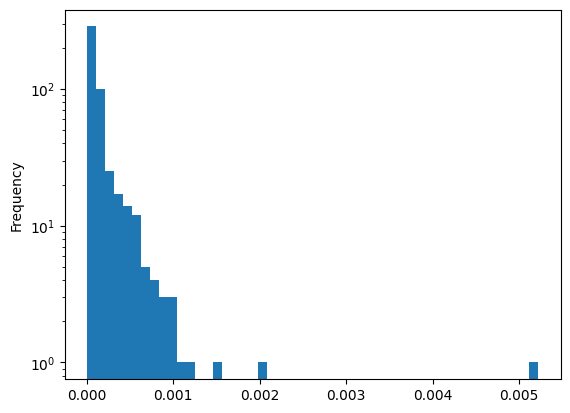

In [156]:
county_hate_rates_df["hate_crime_rate"].plot.hist(bins=50, logy=True)

####Transform hate_rate data to a Gaussian distribution

In [157]:
hate_features = ["hate_crime_count", "hate_crime_rate"]
# save the hate feature data for adding back later
hate_crime_rates_df = county_hate_rates_df[hate_features]

# transform the hate_crime_rate data
transform_standardize_data(county_hate_rates_df, hate_features, [])
county_hate_rates_df = pd.concat([county_hate_rates_df, hate_crime_rates_df], axis=1, join="outer")

hate_rate_numerical_cols = [col for col in county_hate_rates_df.select_dtypes(include=["int64", "float64"]).columns if (("transformed" in col)\
                                                                                                                        or (col in hate_features))]

county_hate_rates_df = county_hate_rates_df[hate_rate_numerical_cols]

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


<Axes: ylabel='Frequency'>

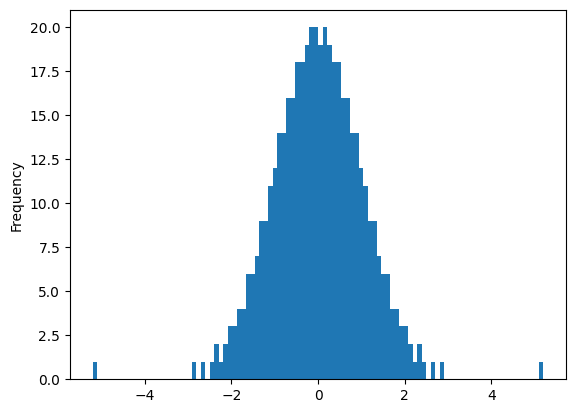

In [158]:
county_hate_rates_df['transformed_hate_crime_rate'].plot.hist(bins=100)

####Create a categorical variable for classification testing

In [163]:
crime_df["region_name"].unique()

array(['South', 'West', 'Midwest', 'Northeast'], dtype=object)

In [164]:
county_hate_rates_df["region"] = crime_df["region_name"].map({"South":3, "West":2, "Midwest":1, "Northeast":0})

In [192]:
# transform the hate_crime_rate data
transform_standardize_data(county_hate_rates_df, ["region"], [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


##Merge the datasets

In [73]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name", "data_year"])

In [74]:
merged_df.drop(other_unique_categorical_cols["pug_agency_name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

In [75]:
merged_df.dropna(axis=1, how="all", inplace=True)

#Data Exploration

##Important Functions

In [76]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.columns = ["feature1", "feature2", "corr"]

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  #filter out stray index rows
  corr_sorted = corr_sorted[~corr_sorted["feature1"].str.contains("level_0|index")]
  corr_sorted = corr_sorted[~corr_sorted["feature2"].str.contains("level_0|index")]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [77]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 20))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=50, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [78]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_d

####Correlation matrix

In [79]:
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_cols:
    crime_numerical_cols.remove(item)

In [80]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_cols].dropna().corr()

In [81]:
# # Set the figure size
# plt.figure(figsize=(200, 100))

# # Create a heatmap of the correlation matrix
# sns.heatmap(crime_corr, annot=True)

# # Show the plot
# plt.show()

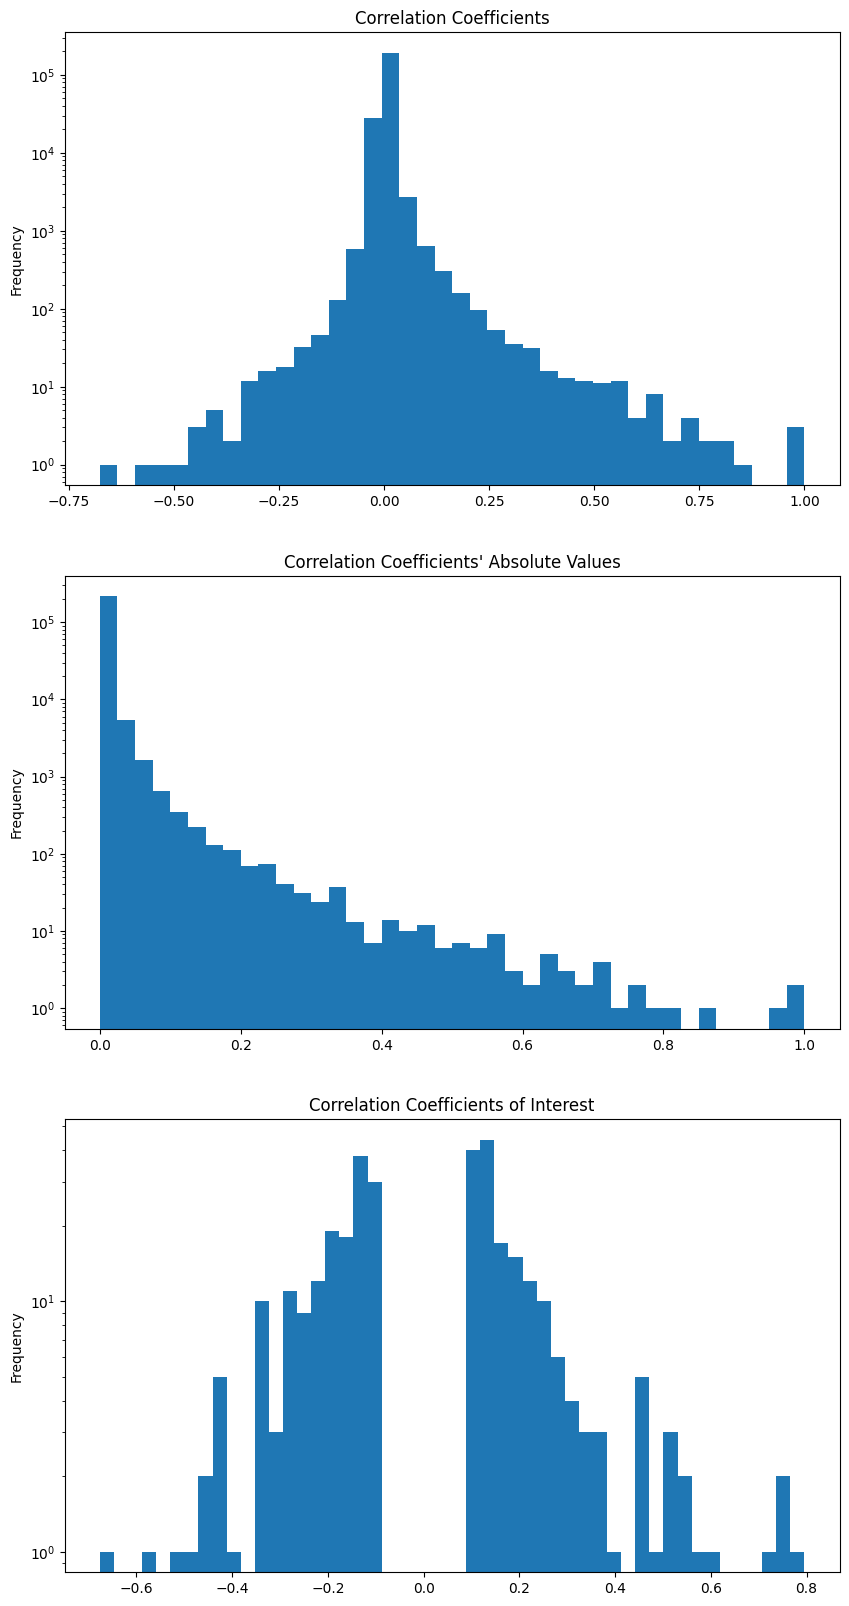

In [82]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.1, 1, "pug_agency_name|state_name")

In [83]:
crime_corrs_of_interest

index                                           feature1  \
681    33365                victim_types_Religious Organization   
683     4120                           total_individual_victims   
685    34010                        victim_types_Society/Public   
693   416275                      division_name_Middle Atlantic   
699   426359                                offender_race_White   
723    78698                        location_name_Other/Unknown   
725   429079                   offender_ethnicity_Not Specified   
727     2037                               adult_offender_count   
745     2717                            juvenile_offender_count   
747     3401                                       victim_count   
755   429759                         offender_ethnicity_Unknown   
759   459688                                 multiple_offense_M   
761        6                                 adult_victim_count   
767    40008  offense_name_Destruction/Damage/Vandalism of P...   
783    40111             offense_name_Drug Equipment Violations   
785      631                                 adult_victim_count   
791    18946                              bias_desc_Anti-Jewish   
795    78133                        location_name_Other/Unknown   
799    32619                                 victim_types_Other   
801    57086                 offense_name_Weapon Law Violations   
807   425057                              offender_race_Unknown   
809     2839                            juvenile_offender_count   
817   425056                              offender_race_Unknown   
825    33996                        victim_types_Society/Public   
827     2668                               adult_offender_count   
831   422965            offender_race_Black or African American   
833    31282                            victim_types_Individual   
839    29243                              victim_types_Business   
847       46                                 adult_victim_count   
851    31292                            victim_types_Individual   
885   427773          offender_ethnicity_Not Hispanic or Latino   
889    29967                 victim_types_Financial Institution   
893    32650                                 victim_types_Other   
895      802                              juvenile_victim_count   
899    32598                                 victim_types_Other   
905   425684                              offender_race_Unknown   
913    33956                        victim_types_Society/Public   
927    31294                            victim_types_Individual   
929    29203                              victim_types_Business   
933    31847                            victim_types_Individual   
935     1361                               total_offender_count   
941    18391                              bias_desc_Anti-Jewish   
947    40009  offense_name_Destruction/Damage/Vandalism of P...   
949    39388  offense_name_Destruction/Damage/Vandalism of P...   
959    52341                        offense_name_Simple Assault   
963    33317                victim_types_Religious Organization   
969    33308                victim_types_Religious Organization   
975    52350                        offense_name_Simple Assault   
987   425667                              offender_race_Unknown   
991    78112                        location_name_Other/Unknown   
997   419559                       division_name_South Atlantic   
1003   31279                            victim_types_Individual   
1013  425736                                offender_race_White   
1021  425102                              offender_race_Unknown   
1029  425081                              offender_race_Unknown   
1033  416233                      division_name_Middle Atlantic   
1045   25217                      bias_desc_Anti-Other Religion   
1049   74130   location_name_Highway/Road/Alley/Street/Sidewalk   
1051   39995  offense_name_Destruction/Damage/Vandalis

####Quantitative variable figures

<Axes: title={'center': 'total_offender_count'}, ylabel='Frequency'>

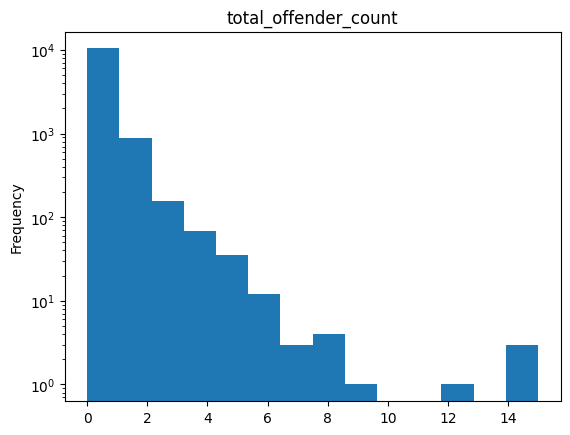

In [84]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

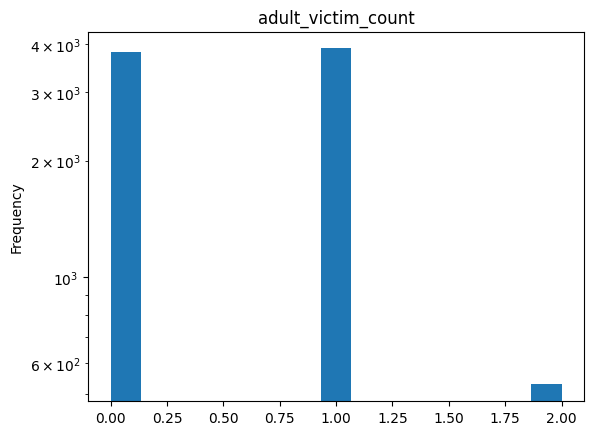

In [85]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

<Axes: title={'center': 'juvenile_victim_count'}, ylabel='Frequency'>

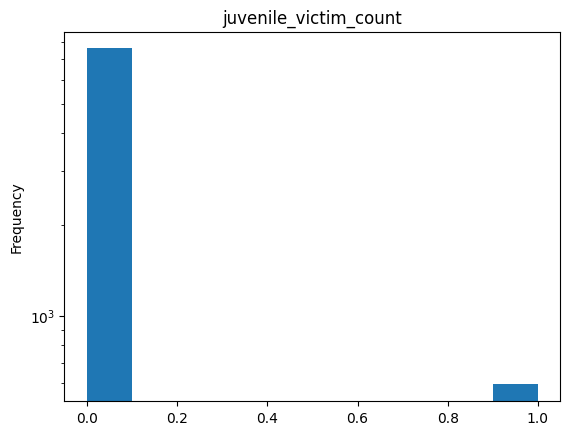

In [86]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [87]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

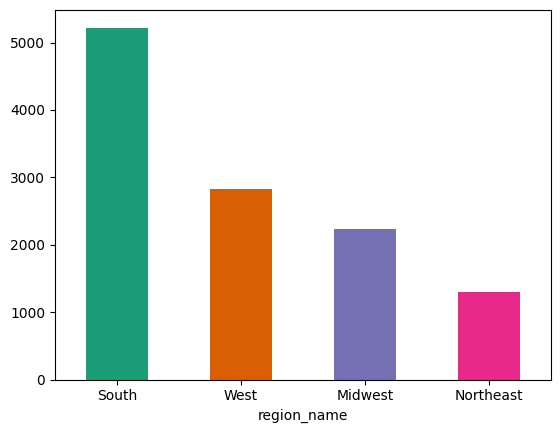

In [88]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

<Axes: ylabel='offender_race'>

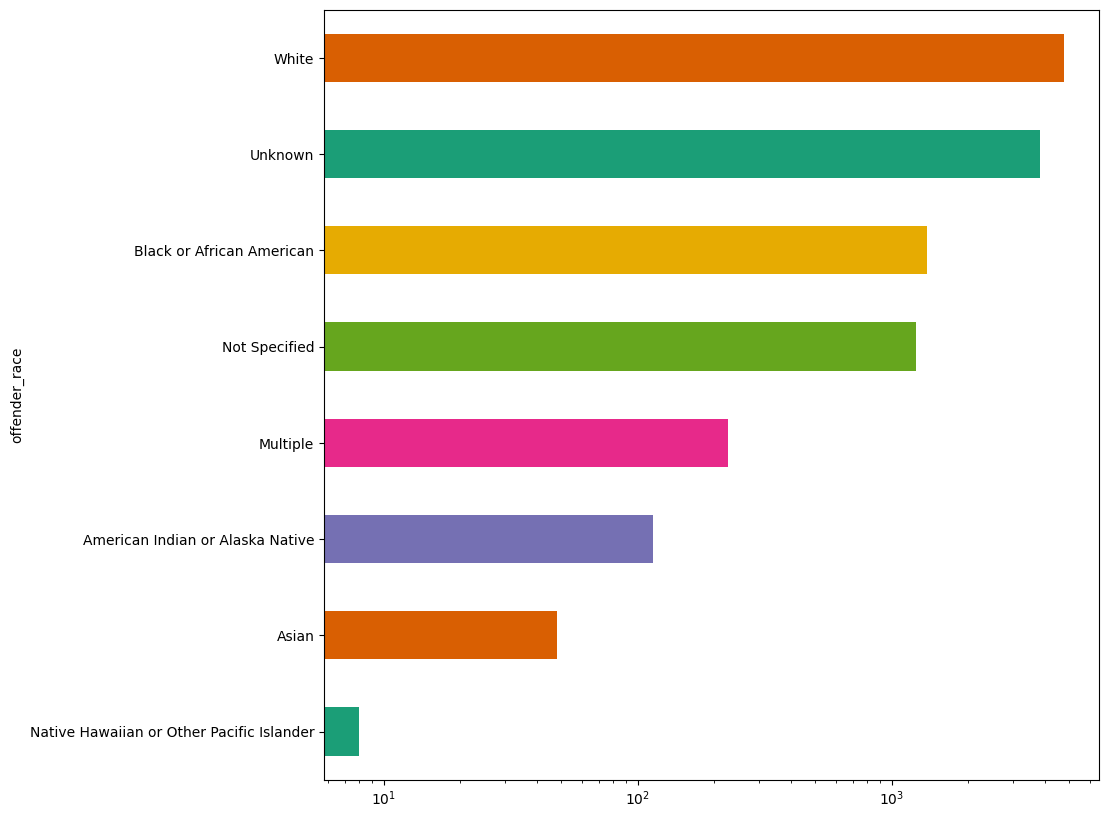

In [89]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

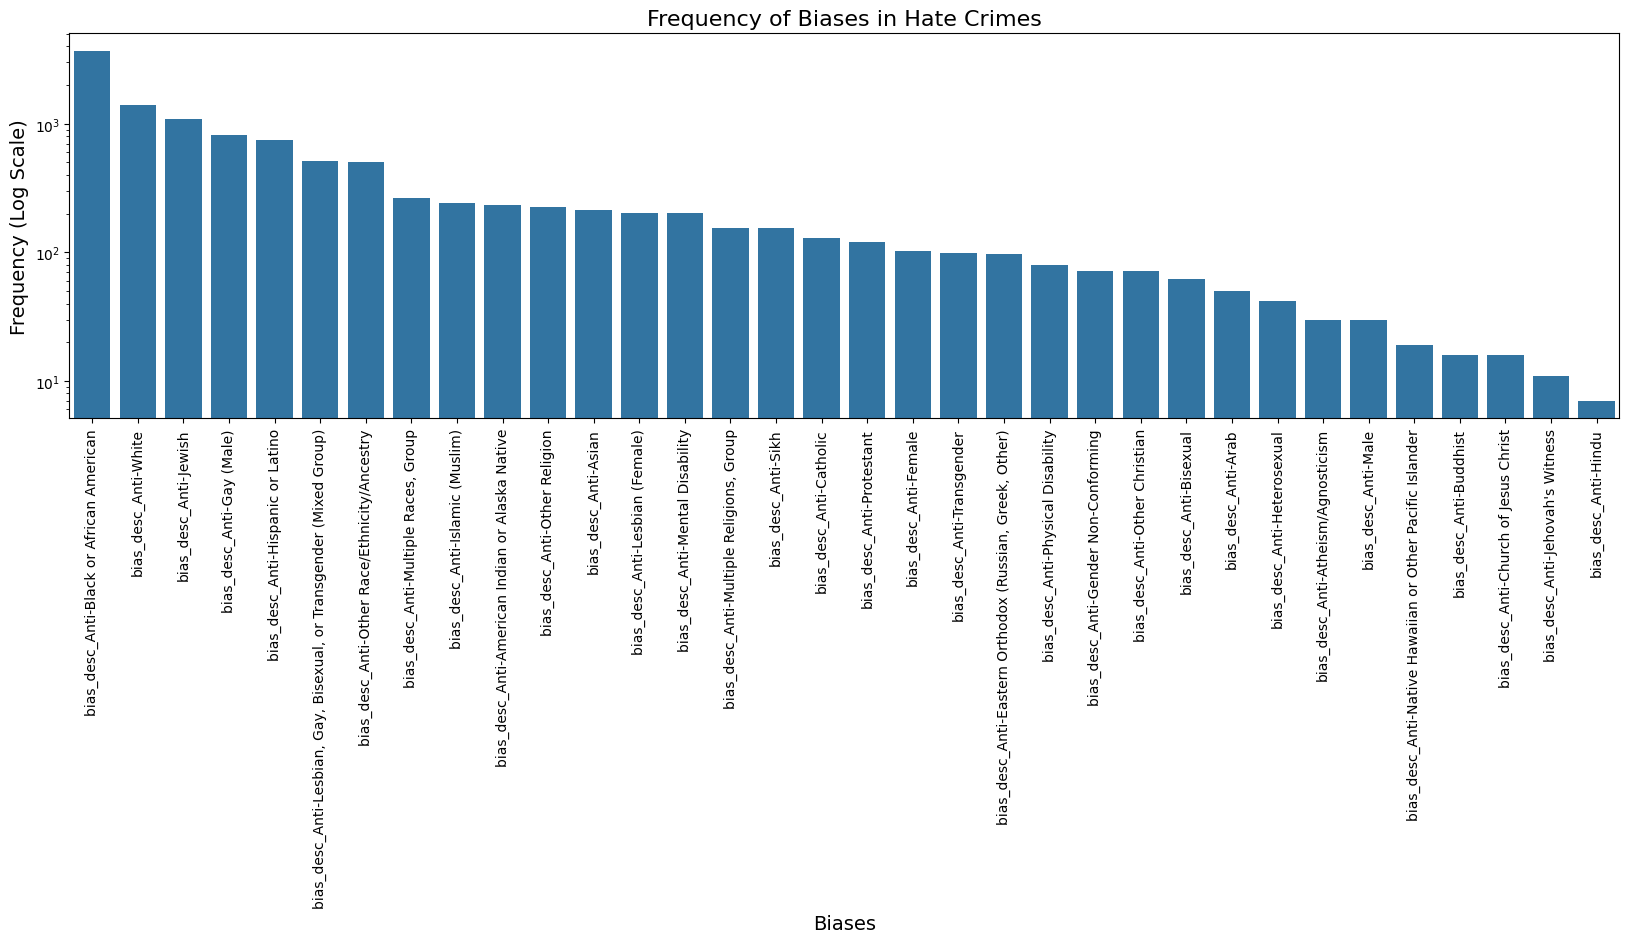

In [90]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

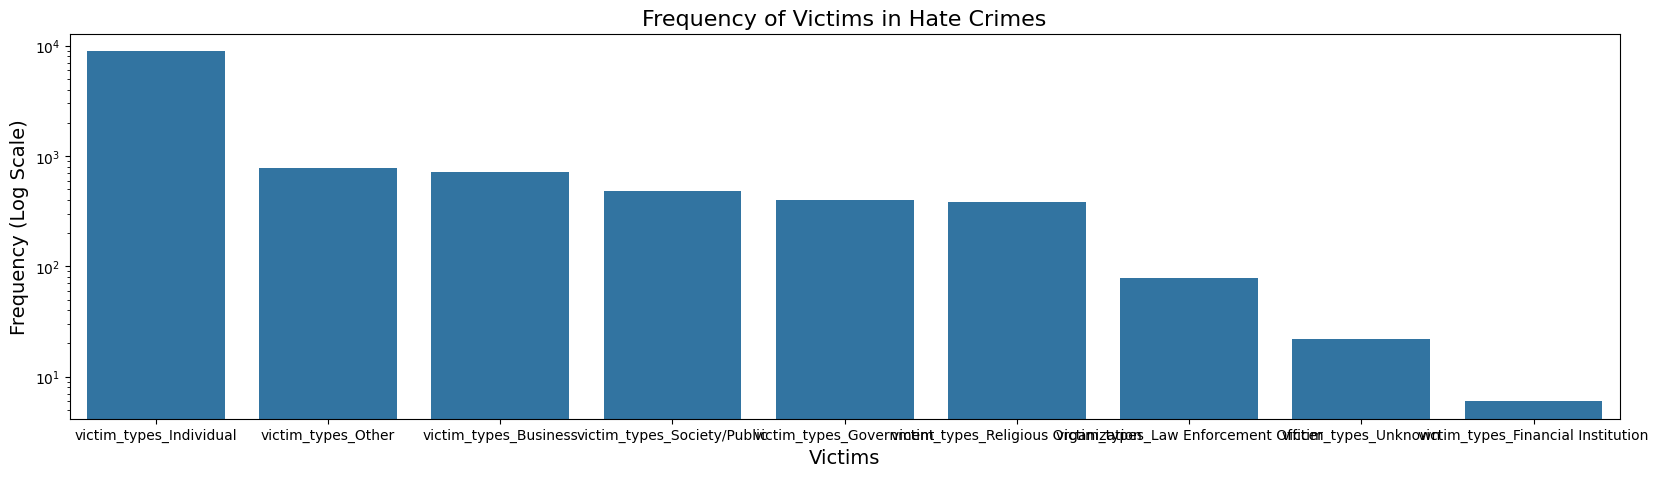

In [91]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

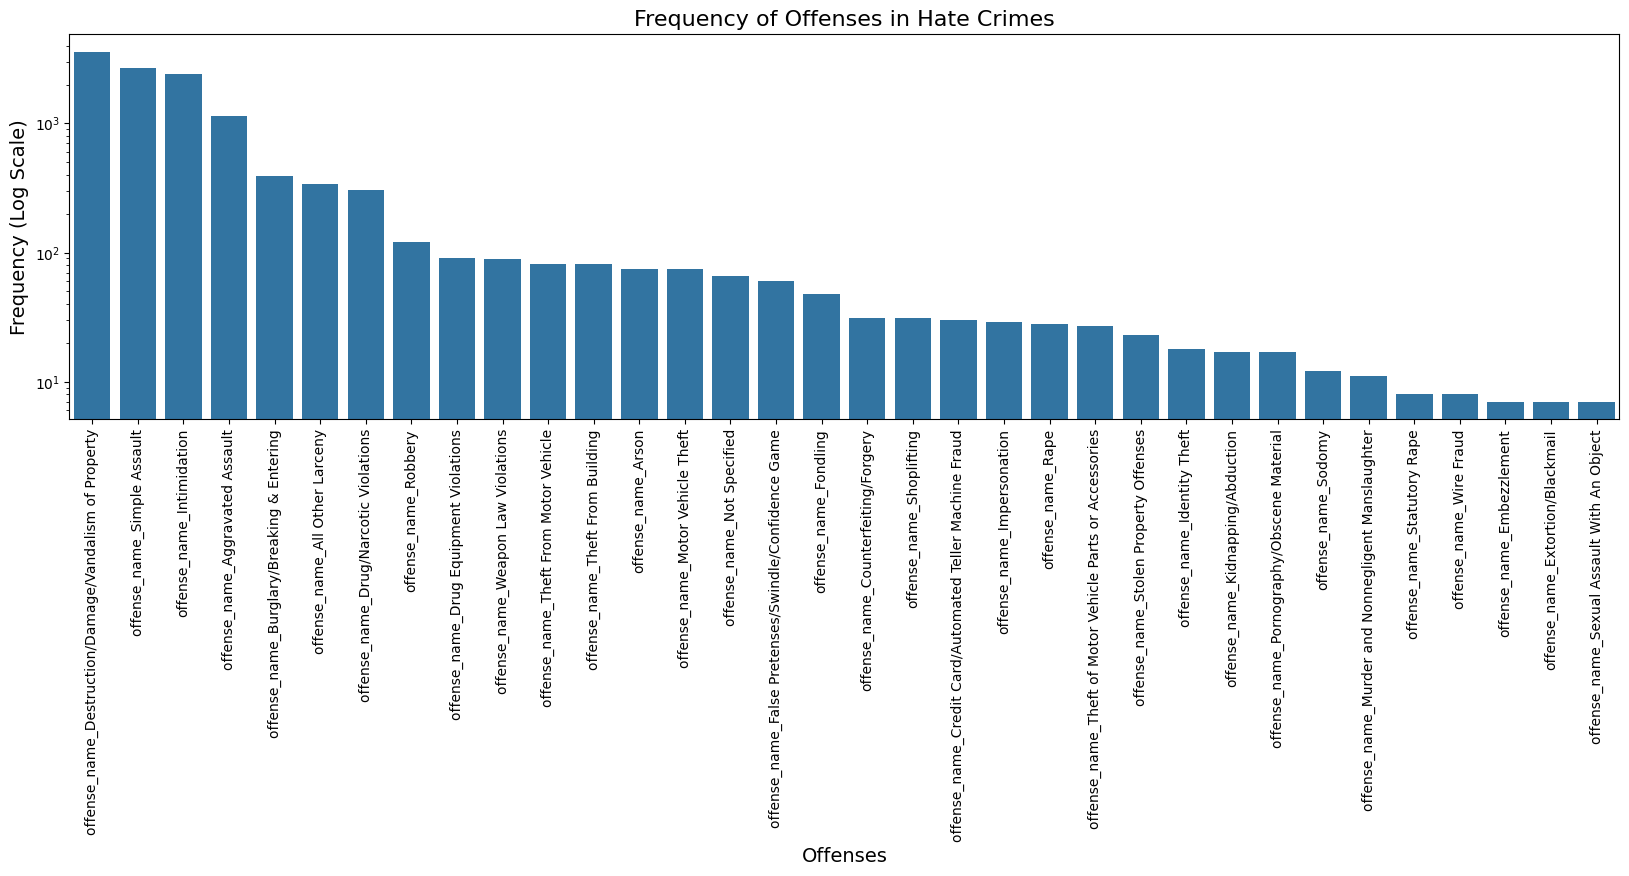

In [92]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

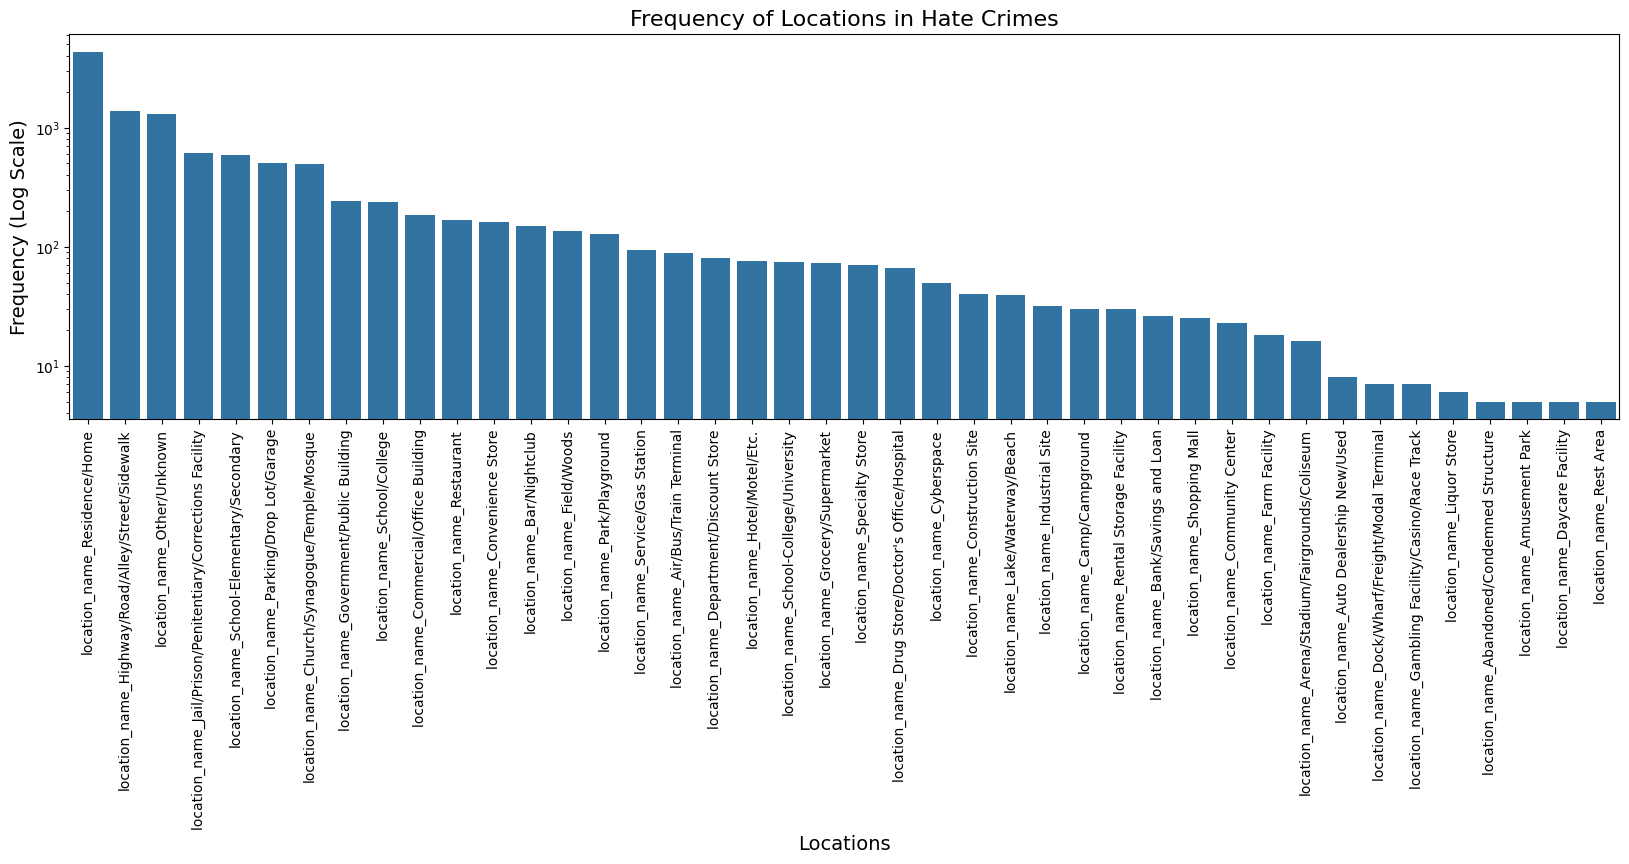

In [93]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [94]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

Text(70.7222222222222, 0.5, 'Offender Race')

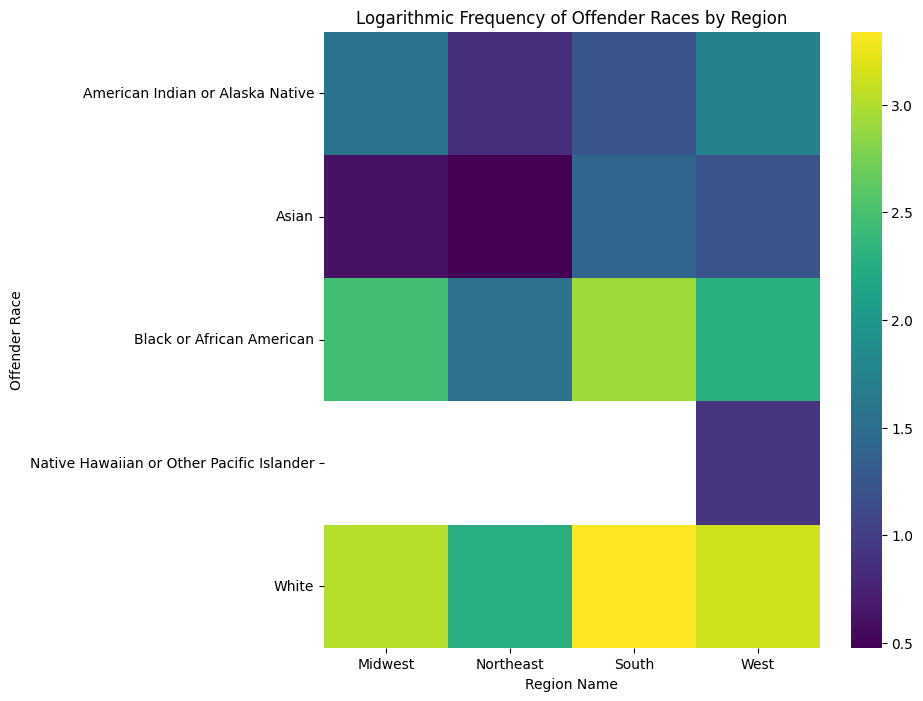

In [95]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [96]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

['bias_desc_Anti-White', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Native Hawaiian or Other Pacific Islander']


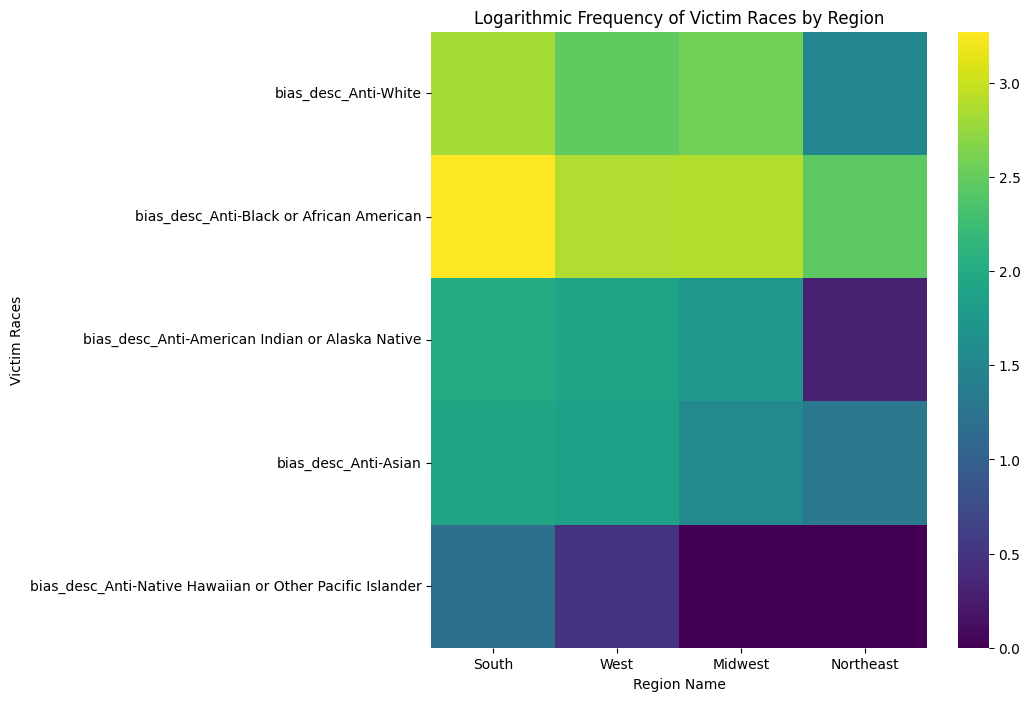

In [97]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        count = 0
        # Sum of occurrences of victim_race in the region
        if victim_race in region_data.columns:
          count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [98]:
county_demo_df.head()

Geography     Geographic Area Name  Total population  \
9138  0500000US01003  Baldwin County, Alabama            246435   
9139  0500000US01015  Calhoun County, Alabama            115788   
9140  0500000US01043  Cullman County, Alabama             90665   
9141  0500000US01049   DeKalb County, Alabama             71998   
9142  0500000US01051   Elmore County, Alabama             89563   

      Percent!!Total population RACE!!Total population  \
9138                   246435.0                 246435   
9139                   115788.0                 115788   
9140                    90665.0                  90665   
9141                    71998.0                  71998   
9142                    89563.0                  89563   

      Percent!!RACE!!Total population  \
9138                         246435.0   
9139                         115788.0   
9140                          90665.0   
9141                          71998.0   
9142                          89563.0   

     RACE!!Race alone or in combination with one or more other races!!Total population  \
9138                                                NaN                                  
9139                                                NaN                                  
9140                                                NaN                                  
9141                                                NaN                                  
9142                                                NaN                                  

      Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
9138                                                NaN                                            
9139                                                NaN                                            
9140                                                NaN                                            
9141                                                NaN                                            
9142                                                NaN                                            

     RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
9138         NaN                   NaN                             NaN   
9139         NaN                   NaN                             NaN   
9140         NaN                   NaN                             NaN   
9141         NaN                   NaN                             NaN   
9142         NaN                   NaN                             NaN   

      Percent!!RACE!!Black or African American  \
9138                                       NaN   
9139                                       NaN   
9140                                       NaN   
9141                                       NaN   
9142                                       NaN   

     RACE!!American Indian and Alaska Native  \
9138                                     NaN   
9139                                     NaN   
9140                                     NaN   
9141                                     NaN   
9142                                     NaN   

      Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
9138                                               NaN         NaN   
9139                                               NaN         NaN   
9140                                               NaN         NaN   
9141                                               NaN         NaN   
9142                                               NaN         NaN   

      Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
9138                   NaN                                              NaN   
9139                   NaN                                              NaN   
9140                   NaN                                              NaN   
9141                   NaN                                              NaN   
9142               

####Correlation matrix

In [99]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)
county_numerical_cols = [col for col in county_numerical_cols if "transformed_" in col]

In [100]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [101]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(county_corr, annot=True)

# # Show the plot
# plt.show()

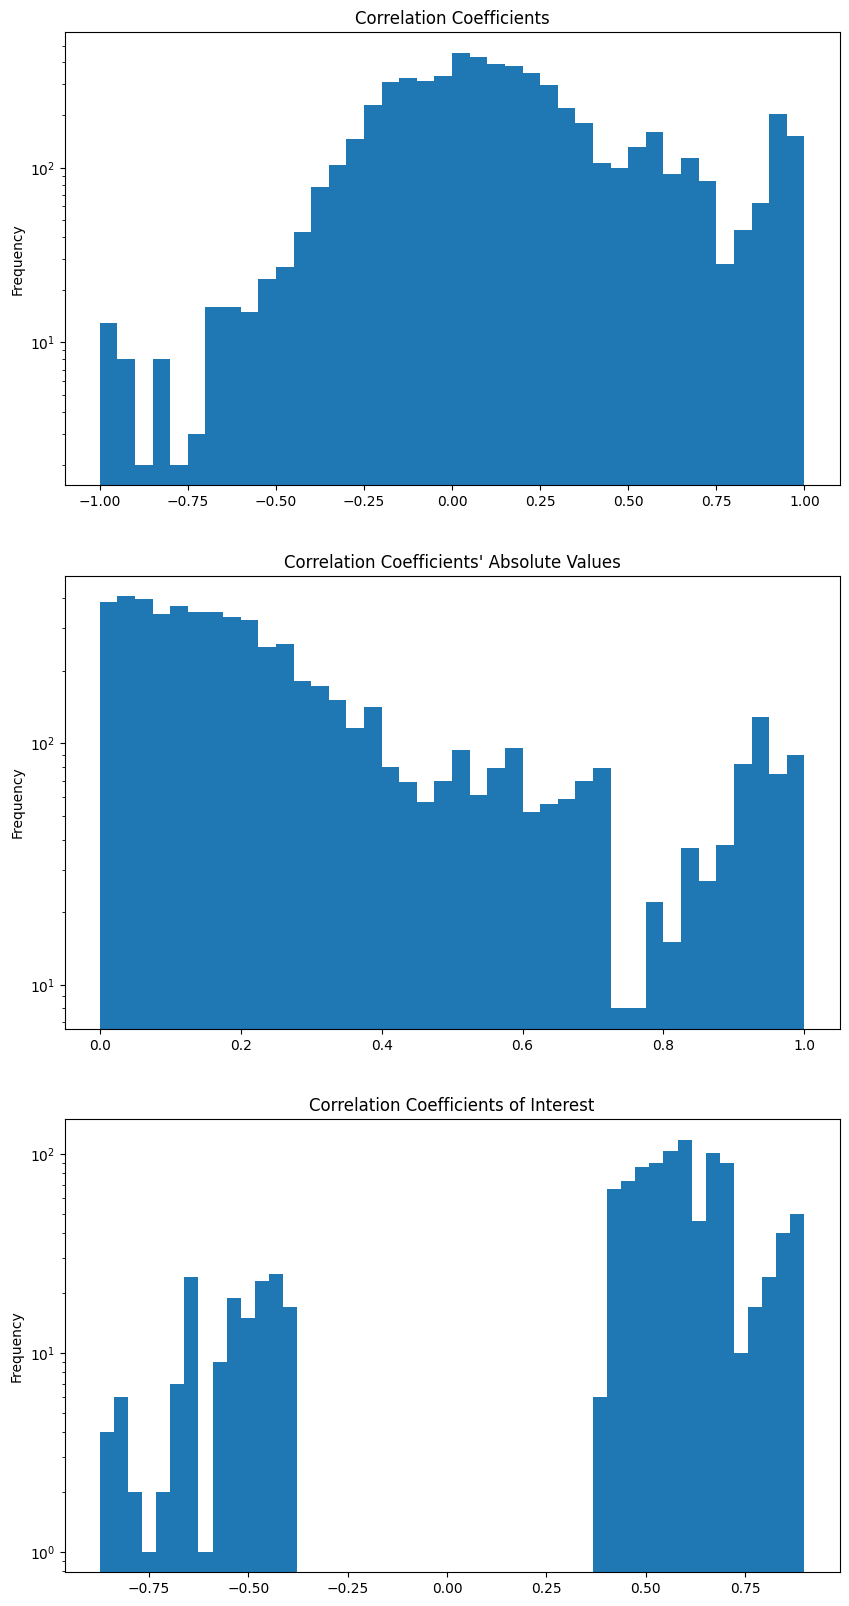

In [102]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.4, 0.9, "pug_agency_name|state_name")

In [103]:
county_corrs_of_interest.reset_index(inplace=True)

In [104]:
county_corrs_of_interest

level_0  index                                           feature1  \
0         862  10679                         transformed_55 to 59 years   
1         864  11114                         transformed_65 to 74 years   
2         866  39895  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
3         868   9806                         transformed_20 to 24 years   
4         870   9820                         transformed_20 to 24 years   
5         872  10688                         transformed_55 to 59 years   
6         874  34227                transformed_Percent!!65 to 74 years   
7         876  39890  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
8         878  12850                      transformed_62 years and over   
9         880  39891  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
10        882  11985                         transformed_Under 18 years   
11        884   9380                         transformed_10 to 14 years   
12        886  10892                         transformed_60 to 64 years   
13        888   9823                         transformed_20 to 24 years   
14        890   9812                         transformed_20 to 24 years   
15        892  11883                     transformed_Median age (years)   
16        894  11538                      transformed_85 years and over   
17        896  11559                      transformed_85 years and over   
18        898   9163                           transformed_5 to 9 years   
19        900  42702  transformed_Percent!!Race alone or in combinat...   
20        902  10893                         transformed_60 to 64 years   
21        904  44456  transformed_Percent!!RACE!!One race!!Native Ha...   
22        906  13507              transformed_18 years and over!!Female   
23        908  12422                      transformed_18 years and over   
24        910  10263                         transformed_35 to 44 years   
25        912  11875                     transformed_Median age (years)   
26        914  10032                         transformed_25 to 34 years   
27        916  11557                      transformed_85 years and over   
28        918   9807                         transformed_20 to 24 years   
29        920  10674                         transformed_55 to 59 years   
30        922  39889  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
31        924  13067                      transformed_65 years and over   
32        926  14152              transformed_65 years and over!!Female   
33        928   9808                         transformed_20 to 24 years   
34        930  10686                         transformed_55 to 59 years   
35        932  11562                      transformed_85 years and over   
36        934   8947                          transformed_Under 5 years   
37        936  43360  transformed_Percent!!Race alone or in combinat...   
38        938  44065       transformed_Percent!!RACE!!Two or More Races   
39        940  10677                         transformed_55 to 59 years   
40        942  10033                         transformed_25 to 34 years   
41        944  10461                         transformed_45 to 54 years   
42        946  10251                         transformed_35 to 44 years   
43        948  40566  transformed_Percent!!RACE!!One race!!Native Ha...   
44        950  10469                         transformed_45 to 54 years   
45        952  11511                      transformed_85 years and over   
46        954  11502                      transformed_85 years and over   
47        956    487        transformed_Percent!!RACE!!Total population   
48        958     53                       transformed_Total population   
49        960  42368  transformed_Percent!!Race alone or in combinat...   
50        962  12849                      transformed_62 years and over   
51        964   9598                         transformed_15 to 19 years   
52        966  32060           

####Scatter Plots

In [105]:
# create a scatter plot for every feature pair in case there's one of interest
for i in range(len(county_corrs_of_interest)):
    row = county_corrs_of_interest.iloc[i]
    # county_demo_df.plot.scatter(x=row["feature1"], y=row["feature2"])

####Other figures

<Axes: xlabel='Under 5 years', ylabel='85 years and over'>

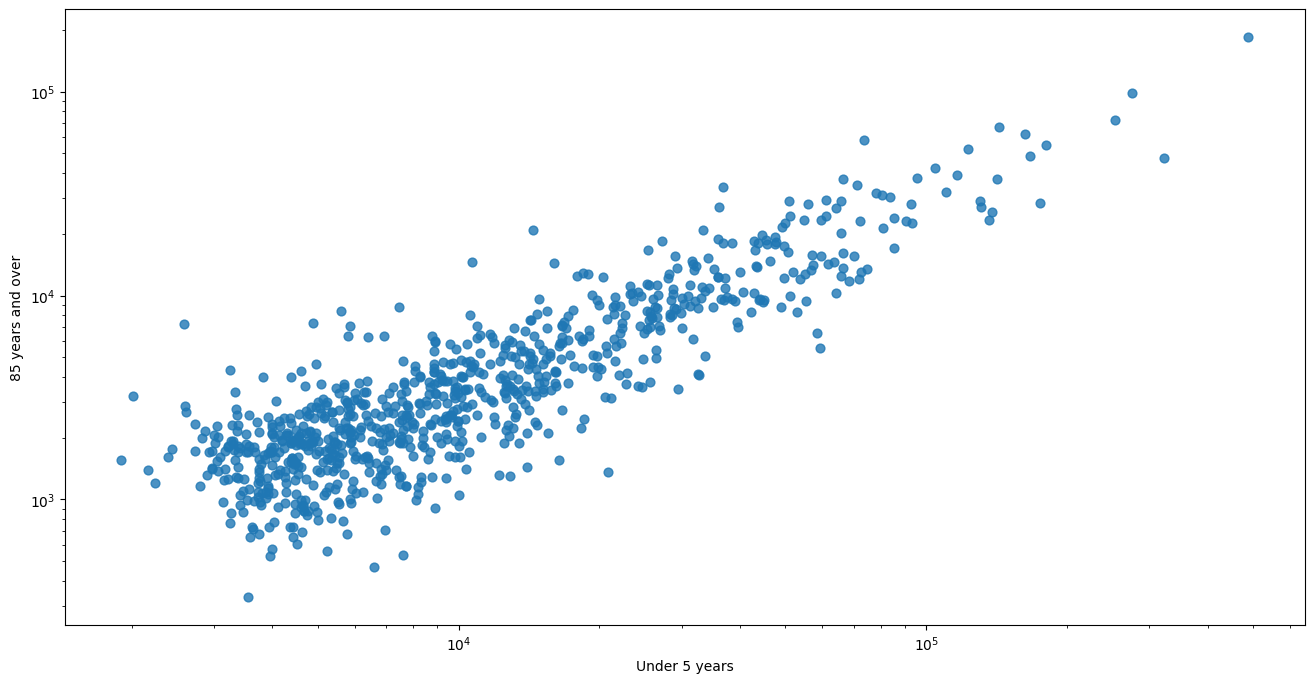

In [106]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

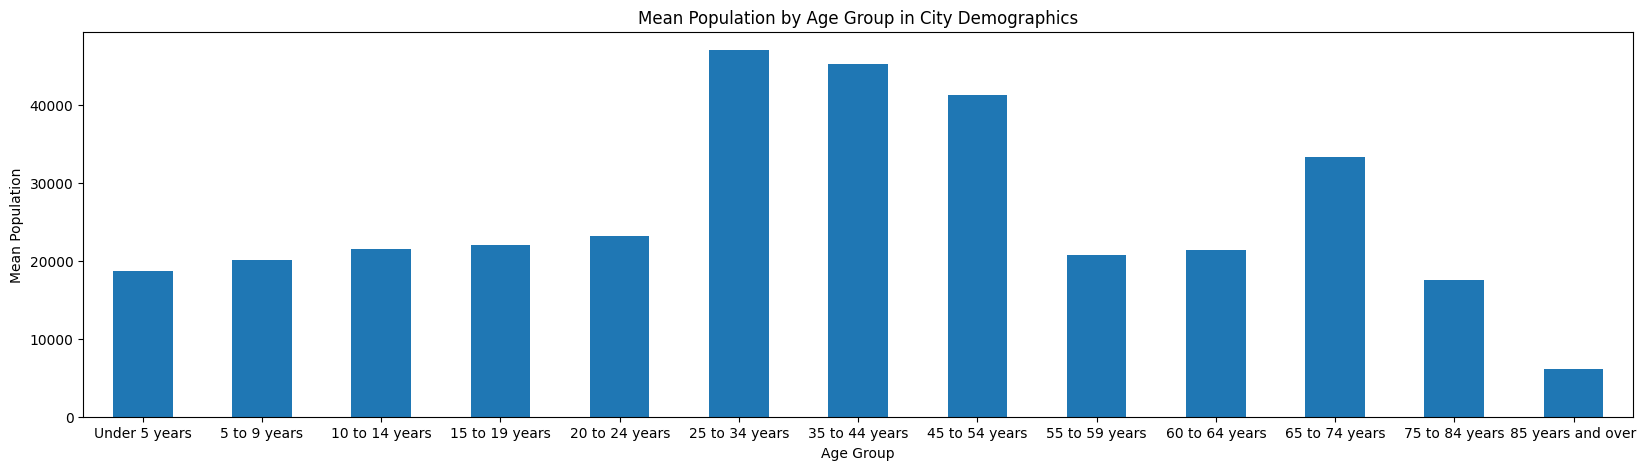

In [107]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

##Merged Datasets

###Primary Merged Dataset

In [108]:
merged_df.head()

level_0   index  incident_id  data_year region_name  adult_victim_count  \
0    10633  230026      1433145       2022       South                 1.0   
1    10638  230044      1468107       2022       South                 0.0   
2    10639  230045      1468108       2022       South                 1.0   
3    10664  230132      1475554       2022       South                 1.0   
4    10665  230134      1475556       2022       South                 1.0   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    0.0                     2                   2.0   
1                    0.0                     1                   1.0   
2                    0.0                     1                   1.0   
3                    0.0                     1                   1.0   
4                    0.0                     1                   1.0   

   juvenile_offender_count  victim_count  \
0                      0.0             1   
1                      0.0             1   
2                      0.0             2   
3                      0.0             1   
4                      0.0             1   

                                        offense_name  \
0                                     Simple Assault   
1           Destruction/Damage/Vandalism of Property   
2  Aggravated Assault;Destruction/Damage/Vandalis...   
3                                 Aggravated Assault   
4                                Motor Vehicle Theft   

   total_individual_victims  incident_month  incident_day  \
0                       1.0               3            11   
1                       0.0               3            10   
2                       1.0               3            13   
3                       1.0               5            31   
4                       1.0              12             5   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     1                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         1   
1                        0                                         0   
2                        0                                         1   
3                        0                                         1   
4                        0                                         0   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                        

####Correlation Matrix Analysis

In [109]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["index", "incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = [col for col in categorical_to_int_df.columns if "transformed_" in col]
# numerical_cols

In [110]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [111]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

index                                     feature1  \
38   1749        transformed_Percent!!Total population   
40   1628                 transformed_Total population   
42   1626                 transformed_Total population   
54   1752        transformed_Percent!!Total population   
56   1873  transformed_Percent!!RACE!!Total population   

                                             feature2  corr  abs_corr  
38                       transformed_Total population   1.0       1.0  
40  transformed_Percent!!HISPANIC OR LATINO AND RA...   1.0       1.0  
42              transformed_Percent!!Total population   1.0       1.0  
54  transformed_Percent!!HISPANIC OR LATINO AND RA...   1.0       1.0  
56                       transformed_Total population   1.0       1.0

In [112]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_cols)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [113]:
merged_corr_sorted.head()

index                             feature1  \
1176    506       transformed_adult_victim_count   
2104    999  transformed_juvenile_offender_count   
2414    997  transformed_juvenile_offender_count   
3182    501       transformed_adult_victim_count   
3580    996  transformed_juvenile_offender_count   

                                  feature2      corr  abs_corr  
1176  transformed_total_individual_victims  0.723124  0.723124  
2104      transformed_adult_offender_count -0.581780  0.581780  
2414     transformed_juvenile_victim_count  0.556983  0.556983  
3182     transformed_juvenile_victim_count -0.495547  0.495547  
3580        transformed_adult_victim_count -0.442350  0.442350

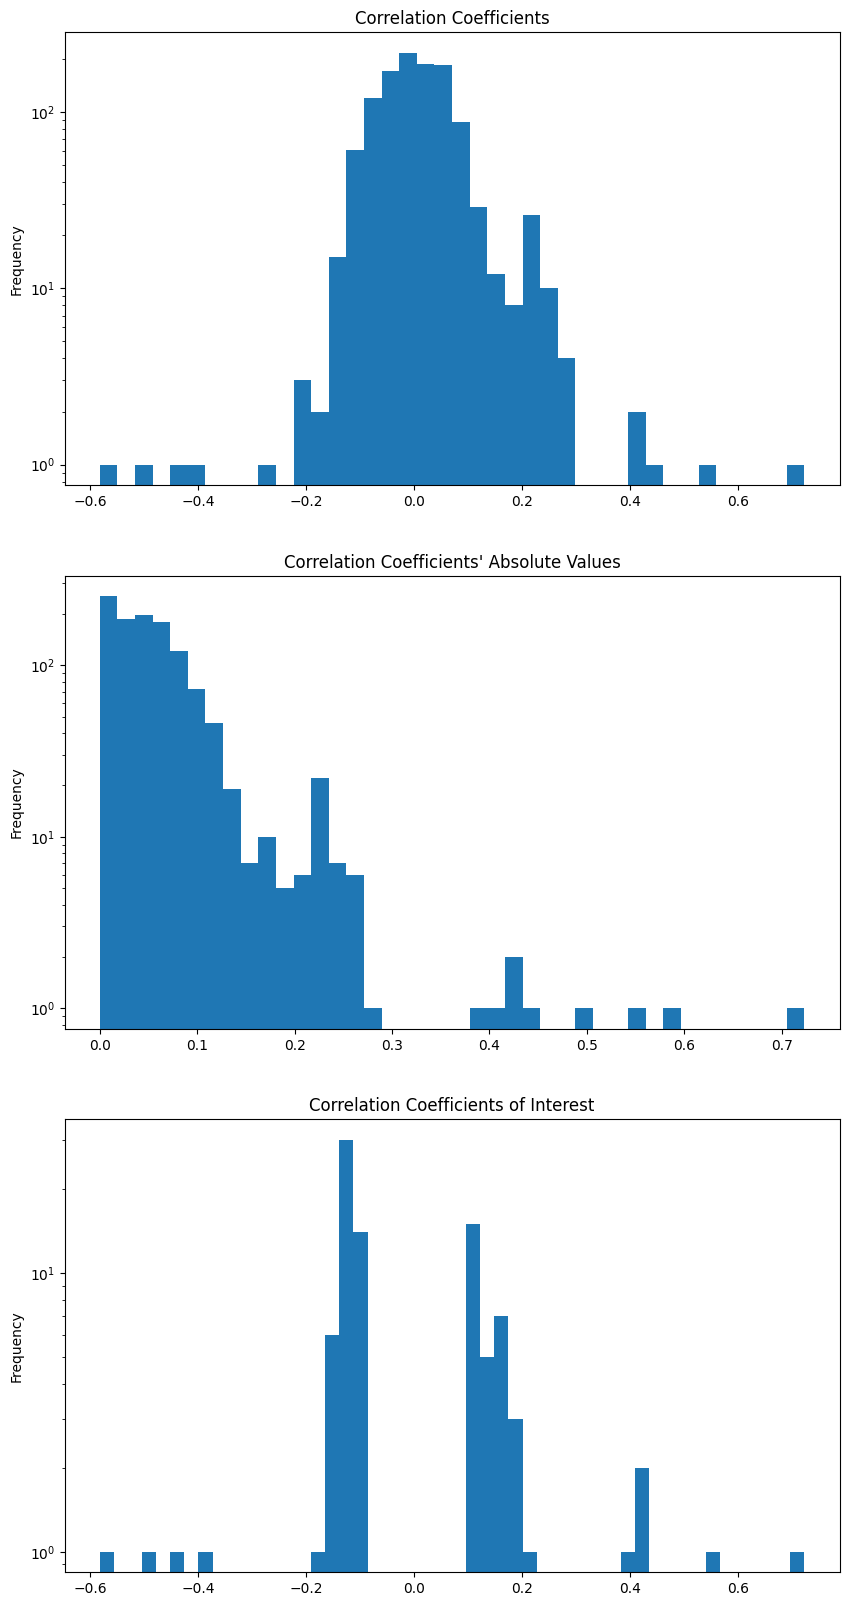

In [114]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.1, 1, "state_name|division_name|pug_agency_name|index|incident_id", merged_corr_sorted)

In [115]:
merged_corrs_of_interest

index                                           feature1  \
1176    506                     transformed_adult_victim_count   
2104    999                transformed_juvenile_offender_count   
2414    997                transformed_juvenile_offender_count   
3182    501                     transformed_adult_victim_count   
3580    996                transformed_juvenile_offender_count   
3652    751                   transformed_total_offender_count   
3702    872                   transformed_adult_offender_count   
3848   1120                           transformed_victim_count   
3866    627                  transformed_juvenile_victim_count   
6856   1126                           transformed_victim_count   
7418    948                   transformed_adult_offender_count   
7462    940                   transformed_adult_offender_count   
7618   9059                transformed_Percent!!75 to 84 years   
7686   9803             transformed_Percent!!62 years and over   
7750   1245               transformed_total_individual_victims   
7816   1123                           transformed_victim_count   
7848   1089                transformed_juvenile_offender_count   
7874   1246               transformed_total_individual_victims   
7888   7944                transformed_Percent!!10 to 14 years   
7926   1057                transformed_juvenile_offender_count   
8012   1247               transformed_total_individual_victims   
8300   5836                         transformed_75 to 84 years   
8326   8563                transformed_Percent!!45 to 54 years   
8338   1040                transformed_juvenile_offender_count   
8370   7324                transformed_65 years and over!!Male   
8398   1069                transformed_juvenile_offender_count   
8400   1067                transformed_juvenile_offender_count   
8416   1047                transformed_juvenile_offender_count   
8438   1052                transformed_juvenile_offender_count   
8446   1038                transformed_juvenile_offender_count   
8448   9680             transformed_Percent!!21 years and over   
8494   1046                transformed_juvenile_offender_count   
8530    942                   transformed_adult_offender_count   
8594   9555             transformed_Percent!!18 years and over   
8602    943                   transformed_adult_offender_count   
8644    516                     transformed_adult_victim_count   
8668   1336               transformed_total_individual_victims   
8712   7943                transformed_Percent!!10 to 14 years   
8720   1037                transformed_juvenile_offender_count   
8750   1032                transformed_juvenile_offender_count   
8756   9432             transformed_Percent!!16 years and over   
8760  12160  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
8764    946                   transformed_adult_offender_count   
8816   8067                transformed_Percent!!15 to 19 years   
8834   1034                transformed_juvenile_offender_count   
8848   1049                transformed_juvenile_offender_count   
8858   3976  transformed_Percent!!Citizen, 18 and over popu...   
8868    944                   transformed_adult_offender_count   
8898   1045                transformed_juvenile_offender_count   
8910   4596                           transformed_5 to 9 years   
8934   1044                transformed_juvenile_offender_count   
8966   1868        transformed_Percent!!RACE!!Total population   
8968   1095                transformed_juvenile_offender_count   
8970   1007                transformed_juvenile_offender_count   
8972   1008                transformed_juvenile_offender_count   
8974   1744              transformed_Percent!!Total population   
8976   5092                         transformed_25 to 34 years   
8978    606                     transformed_adult_victim_count   
8980   1048                transformed_juvenile_offender_count   
8992   6332                      transformed_1

####Other Figures

<Axes: xlabel='transformed_Percent!!RACE!!One race!!White', ylabel='transformed_Percent!!45 to 54 years'>

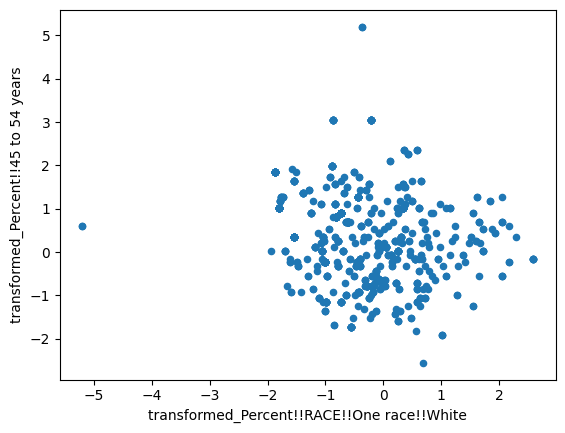

In [116]:
merged_df.plot.scatter(x="transformed_Percent!!RACE!!One race!!White", y="transformed_Percent!!45 to 54 years")

###County Feature Prediction Dataset

In [117]:
county_hate_rates_df.head()

transformed_Total population  transformed_Percent!!Total population  \
1                      0.336203                               0.336203   
2                      1.115905                               1.115905   
4                      0.117165                               0.117165   
5                     -1.722351                              -1.722351   
6                      0.501111                               0.501111   

   transformed_Percent!!RACE!!Total population  \
1                                     0.336203   
2                                     1.115905   
4                                     0.117165   
5                                    -1.722351   
6                                     0.501111   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
1                                           0.336203                    
2                                           1.115905                    
4                                           0.117165                    
5                                          -1.722351                    
6                                           0.501111                    

   transformed_data_year  transformed_Percent!!Male  \
1              -5.199338                   0.666154   
2              -5.199338                  -0.359785   
4              -5.199338                  -0.559016   
5              -5.199338                   2.244607   
6              -5.199338                  -1.599096   

   transformed_Percent!!Female  transformed_Percent!!RACE!!One race  \
1                    -0.664308                             0.824455   
2                     0.359785                            -0.785580   
4                     0.559016                            -0.292668   
5                    -2.244607                             0.317472   
6                     1.593804                            -0.004439   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                          -0.219262                                    
2                                           0.793664                                    
4                                           0.501111                                    
5                                          -0.864617                                    
6                                          -0.102278                                    

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
1                                          -0.345612                                             
2                                           0.039963                                             
4                                           1.118667                                             
5                                          -5.199338                                             
6                                           0.501111                                             

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
1                                           0.847540                                                  
2                                           1.749044                                                  
4                                           0.226847                                                  
5                                          -5.199338                                                  
6                                           0.115675                                                  

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
1                                           0.709268                                           
2                                           2.145947                                           
4                            

####Correlation Analysis

In [118]:
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols].corr()

In [119]:
hate_rate_corr.head()

transformed_Total population  \
transformed_Total population                                                 1.0   
transformed_Percent!!Total population                                        1.0   
transformed_Percent!!RACE!!Total population                                  1.0   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                           1.0   
transformed_data_year                                                        NaN   

                                                    transformed_Percent!!Total population  \
transformed_Total population                                                          1.0   
transformed_Percent!!Total population                                                 1.0   
transformed_Percent!!RACE!!Total population                                           1.0   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                                    1.0   
transformed_data_year                                                                 NaN   

                                                    transformed_Percent!!RACE!!Total population  \
transformed_Total population                                                                1.0   
transformed_Percent!!Total population                                                       1.0   
transformed_Percent!!RACE!!Total population                                                 1.0   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                                          1.0   
transformed_data_year                                                                       NaN   

                                                    transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
transformed_Total population                                                                      1.0                    
transformed_Percent!!Total population                                                             1.0                    
transformed_Percent!!RACE!!Total population                                                       1.0                    
transformed_Percent!!HISPANIC OR LATINO AND RAC...                                                1.0                    
transformed_data_year                                                                             NaN                    

                                                    transformed_data_year  \
transformed_Total population                                          NaN   
transformed_Percent!!Total population                                 NaN   
transformed_Percent!!RACE!!Total population                           NaN   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                    NaN   
transformed_data_year                                                 NaN   

                                                    transformed_Percent!!Male  \
transformed_Total population                                        -0.150706   
transformed_Percent!!Total population                               -0.150706   
transformed_Percent!!RACE!!Total population                         -0.150706   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                  -0.150706   
transformed_data_year                                                     NaN   

                                                    transformed_Percent!!Female  \
transformed_Total population                                           0.150678   
transformed_Percent!!Total population                                  0.150678   
transformed_Percent!!RACE!!Total population                            0.150678   
transformed_Percent!!HISPANIC OR LATINO AND RAC...                     0.150678   
transformed_data_year                                                       NaN   

                                                    transformed_Percent!!RACE!!One race  \
transformed_Total population                                                  -0.475501   
transformed_Percent!!Total po

In [120]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(hate_rate_corr, annot=True)

# # Show the plot
# plt.show()

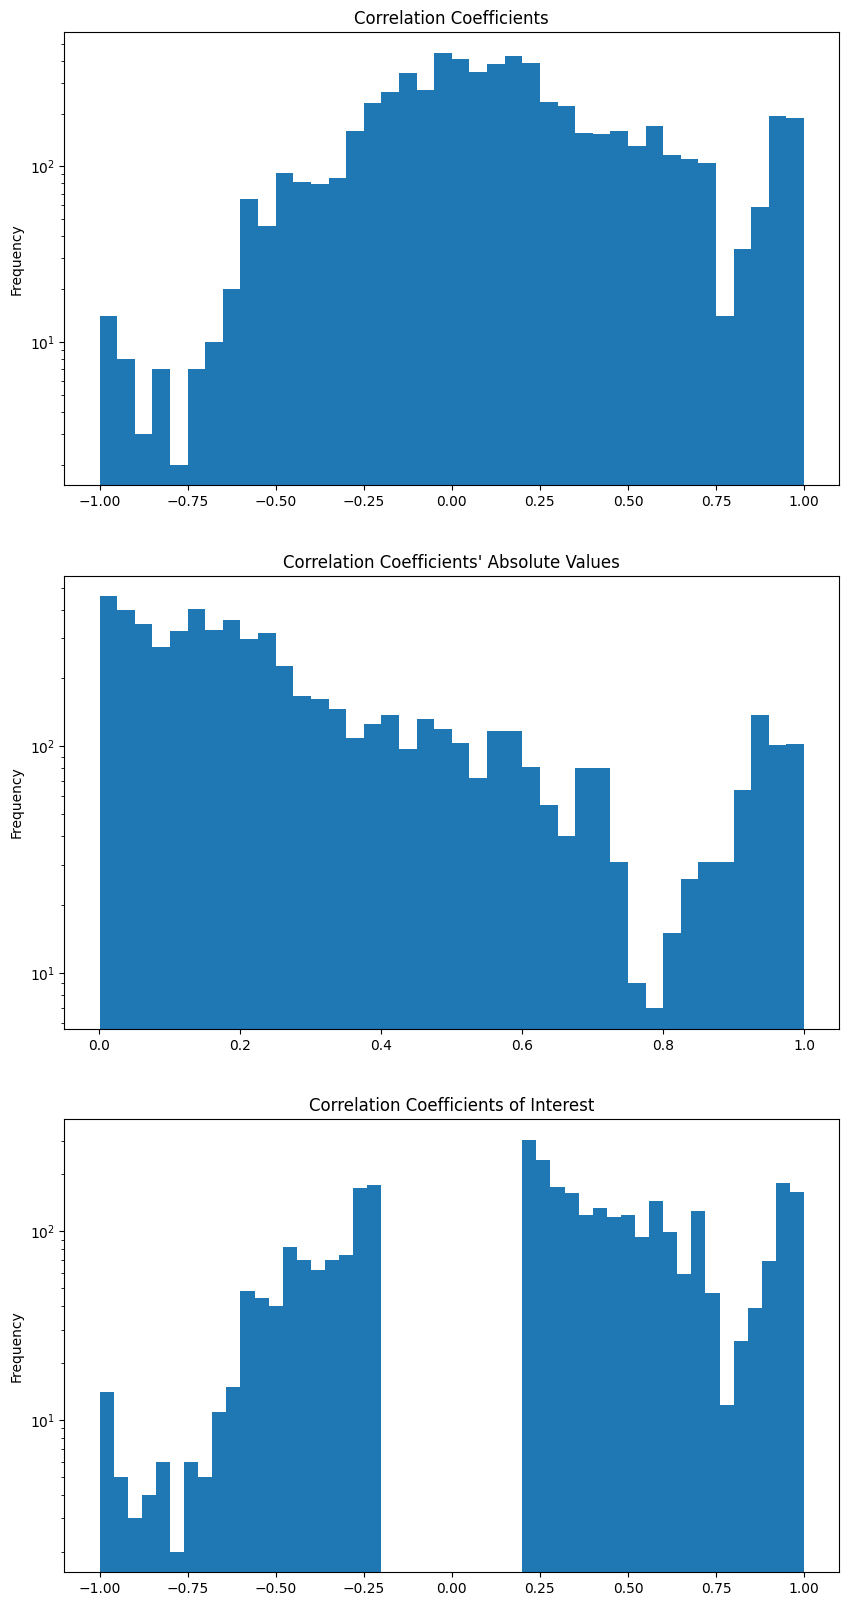

In [121]:
# hate_rate_corr.set_index(["state_name", "division_name", "pug_agency_name"], inplace=True)
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr, 0.2, 1.01, "state_name|division_name|pug_agency_name")

In [122]:
# look at just the correlations between the hate crime rate and other features
hate_rate_corrs_of_interest = extracted_corrs_of_interest\
                                [(extracted_corrs_of_interest["feature1"] == "transformed_hate_crime_rate")\
                                  | (extracted_corrs_of_interest["feature2"] == "transformed_hate_crime_rate")]\
                                .sort_values(ascending=False, by="abs_corr")\
                                .dropna()

<Axes: title={'center': 'Hate Crime Rate Correlation Coefficient Frequencies'}, ylabel='Frequency'>

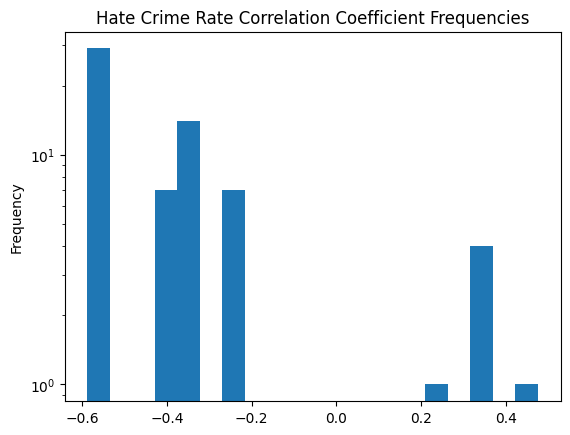

In [123]:
hate_rate_corrs_of_interest['corr'].plot.hist(bins=20, title='Hate Crime Rate Correlation Coefficient Frequencies', logy=True)

####Scatter Plots

In [124]:
# for feature in hate_rate_corrs_of_interest.index:
#   county_hate_rates_df.plot.scatter(x=feature, y="transformed_hate_crime_rate")

#Data Prediction

In [125]:
# designate the training data
training_cols = [col for col in hate_rate_numerical_cols if (not "hate_crime_rate" in col) and ("transformed_" in col) and col in county_hate_rates_df.columns]
x_train_df = county_hate_rates_df[training_cols]
y_train_df = county_hate_rates_df["transformed_hate_crime_rate"]
x_train_df.dropna(inplace=True)
y_train_df.dropna(inplace=True)

In [126]:
x_train_df.head()

transformed_Total population  transformed_Percent!!Total population  \
1                      0.336203                               0.336203   
2                      1.115905                               1.115905   
4                      0.117165                               0.117165   
5                     -1.722351                              -1.722351   
6                      0.501111                               0.501111   

   transformed_Percent!!RACE!!Total population  \
1                                     0.336203   
2                                     1.115905   
4                                     0.117165   
5                                    -1.722351   
6                                     0.501111   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
1                                           0.336203                    
2                                           1.115905                    
4                                           0.117165                    
5                                          -1.722351                    
6                                           0.501111                    

   transformed_data_year  transformed_Percent!!Male  \
1              -5.199338                   0.666154   
2              -5.199338                  -0.359785   
4              -5.199338                  -0.559016   
5              -5.199338                   2.244607   
6              -5.199338                  -1.599096   

   transformed_Percent!!Female  transformed_Percent!!RACE!!One race  \
1                    -0.664308                             0.824455   
2                     0.359785                            -0.785580   
4                     0.559016                            -0.292668   
5                    -2.244607                             0.317472   
6                     1.593804                            -0.004439   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                          -0.219262                                    
2                                           0.793664                                    
4                                           0.501111                                    
5                                          -0.864617                                    
6                                          -0.102278                                    

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
1                                          -0.345612                                             
2                                           0.039963                                             
4                                           1.118667                                             
5                                          -5.199338                                             
6                                           0.501111                                             

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
1                                           0.847540                                                  
2                                           1.749044                                                  
4                                           0.226847                                                  
5                                          -5.199338                                                  
6                                           0.115675                                                  

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
1                                           0.709268                                           
2                                           2.145947                                           
4                            

In [127]:
y_train_df.head()

1   -0.817746
2   -0.950670
4    0.058204
5    0.465812
6    0.430727
Name: transformed_hate_crime_rate, dtype: float64

##Hate Crime Rate Regression

MAE, f1-score, sensitivity, specificity
Cross-validation with test sets and k-fold

In [128]:
# designate a single feature for viewing the model's predictions relative to its transformed value
review_features = "transformed_Percent!!RACE!!One race!!White"
x = pd.DataFrame(x_train_df[review_features])

In [129]:
x.head()

transformed_Percent!!RACE!!One race!!White
1                                    0.423703
2                                   -0.060705
4                                    0.038482
5                                    1.193725
6                                    0.545229

###Linear Regression on All Transformed Data

Create loadings plot

In [130]:
hate_regression_model = LinearRegression()
hate_regression_model.fit(
    X=x,
    y=y_train_df
)

LinearRegression()

In [131]:
coefficients = hate_regression_model.coef_
intercept = hate_regression_model.intercept_

####Observe regression line for individual feature

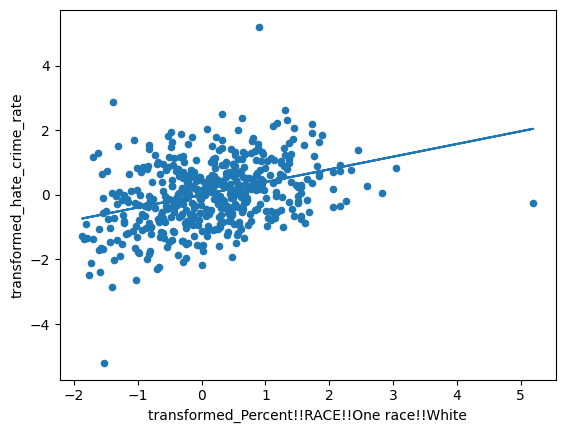

In [132]:
# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features, y="transformed_hate_crime_rate")

#replace coefficients[0] with coefficients[x_train_df.columns.get_loc(review_features)] if training on x_train_df
y_pred = pd.Series(coefficients[0] * x[review_features])

# plot the line of best fit
plt.plot(x, y_pred)


In [133]:
lr_rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
print("Linear Regression RMSE: " + str(lr_rmse))

Linear Regression RMSE: 0.9764043918457589


###K-Nearest-Neighbors on Review Feature

<Axes: xlabel='k', ylabel='transformed_hate_crime_rate'>

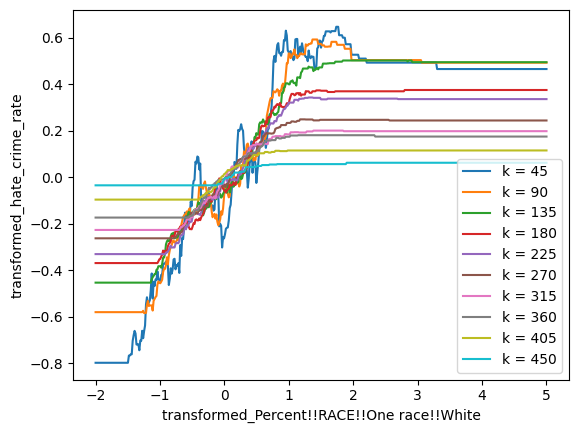

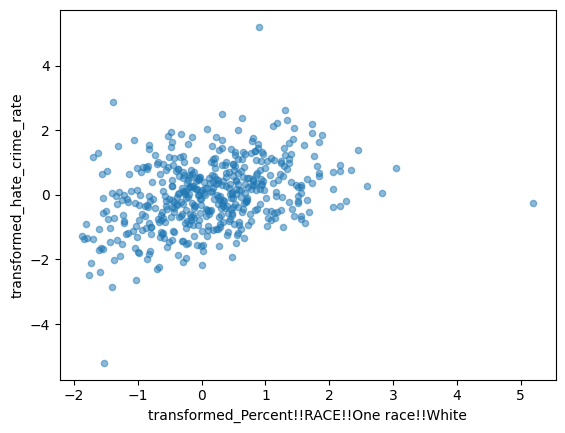

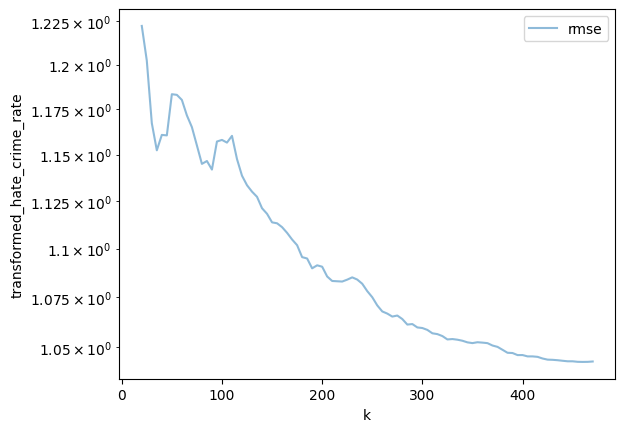

In [134]:
# reformat the training data
x = pd.DataFrame(x_train_df[review_features])

# create the test data
x_test = pd.DataFrame()
x_test[review_features] = np.linspace(-2, 5, len(y_train_df))

rmse_by_k_df = pd.DataFrame({
    "k": [np.nan],
    "rmse": [np.nan]
})

increment = 0.02
# try various different values of k
for k in range(20, len(x), 5):
    # create and fit the model
    hate_knn_model = KNeighborsRegressor(n_neighbors=k)
    hate_knn_model.fit(X=x, y=y_train_df)

    # get the model's predictions
    y_pred = pd.Series(
        hate_knn_model.predict(x_test),
        index=x_test[review_features]
    )

    rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
    entry = {
        "k": k,
        "rmse": rmse
    }

    rmse_by_k_df.loc[len(rmse_by_k_df)] = entry

    if (k % int(increment * len(x_train_df)) == 0):
      # plot knn model predictions
      y_pred.plot.line(ylabel="transformed_hate_crime_rate",\
                      label=("k = " + str(k)))\
                      .legend()


rmse_by_k_df.dropna(inplace=True)
# rmse_by_k_df.set_index("k", inplace=True)

# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features,\
                                  y="transformed_hate_crime_rate",\
                                  alpha=0.5,\
                                  ylabel="transformed_hate_crime_rate")

# create a scatter plot of the rmse's
rmse_by_k_df.plot.line(x="k",\
                       y="rmse",\
                       alpha=0.5,\
                       logy=True,\
                       ylabel="transformed_hate_crime_rate")

In [135]:
rmse_by_k_df.head()

k      rmse
1  20.0  1.222124
2  25.0  1.202241
3  30.0  1.167223
4  35.0  1.152335
5  40.0  1.160750

###Comparison of Methods

In [136]:
print("Linear Regression RMSE:\t" + str(lr_rmse))
print("Lowest KNN RMSE:\t" + str(rmse_by_k_df["rmse"].min()))

Linear Regression RMSE:	0.9764043918457589
Lowest KNN RMSE:	1.0426292911095398


##Region Classification by Demographics

In [284]:
classification_df = county_hate_rates_df[training_cols + ["region", "transformed_hate_crime_rate"]]

In [285]:
region_name_map = {
    0:"Northeast",
    1:"Midwest",
    2:"West",
    3:"South"
}

color_map = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple'
}

###K-Means Clustering

In [286]:
classification_df.head()

transformed_Total population  transformed_Percent!!Total population  \
1                      0.336203                               0.336203   
2                      1.115905                               1.115905   
4                      0.117165                               0.117165   
5                     -1.722351                              -1.722351   
6                      0.501111                               0.501111   

   transformed_Percent!!RACE!!Total population  \
1                                     0.336203   
2                                     1.115905   
4                                     0.117165   
5                                    -1.722351   
6                                     0.501111   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
1                                           0.336203                    
2                                           1.115905                    
4                                           0.117165                    
5                                          -1.722351                    
6                                           0.501111                    

   transformed_data_year  transformed_Percent!!Male  \
1              -5.199338                   0.666154   
2              -5.199338                  -0.359785   
4              -5.199338                  -0.559016   
5              -5.199338                   2.244607   
6              -5.199338                  -1.599096   

   transformed_Percent!!Female  transformed_Percent!!RACE!!One race  \
1                    -0.664308                             0.824455   
2                     0.359785                            -0.785580   
4                     0.559016                            -0.292668   
5                    -2.244607                             0.317472   
6                     1.593804                            -0.004439   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                          -0.219262                                    
2                                           0.793664                                    
4                                           0.501111                                    
5                                          -0.864617                                    
6                                          -0.102278                                    

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
1                                          -0.345612                                             
2                                           0.039963                                             
4                                           1.118667                                             
5                                          -5.199338                                             
6                                           0.501111                                             

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
1                                           0.847540                                                  
2                                           1.749044                                                  
4                                           0.226847                                                  
5                                          -5.199338                                                  
6                                           0.115675                                                  

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
1                                           0.709268                                           
2                                           2.145947                                           
4                            

####Feature selection

In [301]:
# create the classifier
km_model = KMeans(n_clusters=4, random_state=69)

best_clustering = {
    "features": [],
    "k": 0,
    "silhouette_score": -1
}

In [302]:
# saved to skip below and reduce future runtime
best_clustering = {
    "features": ['transformed_Percent!!RACE!!One race!!Asian!!Asian Indian',\
                   'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'],
    "k": 4,
    "silhouette_score": 0.7786296441943121
}

In [303]:
# clusterable_feature_pairs = []

# for k in [4]:
#   for i in range(int((4 * len(extracted_sorted_corrs))/8), int((5 * len(extracted_sorted_corrs))/8)):  #len(extracted_sorted_corrs)):
#       row = extracted_sorted_corrs.iloc[i]

#       features = list(row[["feature1", "feature2"]])

#       # create the classifier
#       km_model = KMeans(n_clusters=k, random_state=69)

#       x = classification_df[features + ["region"]]

#       # # fit the classifier to the feature data
#       # km_model.fit(x)

#       # cluster the features
#       predictions = km_model.fit_predict(x)

#       # get the silhouette score
#       silhouette_score = metrics.silhouette_score(x, predictions)

#       # If it's got some pretty good clusters
#       if (silhouette_score > 0.5):
#         clusterable_feature_pairs.append(features)

#         #if it's got good enough clusters, display it
#         if (silhouette_score > 0.9):
#           county_hate_rates_df.plot.scatter(x=row["feature1"],\
#                                       y=row["feature2"],\
#                                       title="Silhouette Score = " + str(silhouette_score),\
#                                       figsize=(12, 12))

#       if (silhouette_score > best_clustering["silhouette_score"]):
#         best_clustering["features"] = features
#         best_clustering["k"] = k
#         best_clustering["silhouette_score"] = silhouette_score


# print("Total clustered feature pairs: " + str(len(clusterable_feature_pairs)))

In [304]:
print(best_clustering)

{'features': ['transformed_Percent!!RACE!!One race!!Asian!!Asian Indian', 'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'], 'k': 4, 'silhouette_score': 0.7786296441943121}


In [305]:
review_features = list(best_clustering["features"])
print(review_features)

['transformed_Percent!!RACE!!One race!!Asian!!Asian Indian', 'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone']


####Clustering

In [306]:
# fit the classifier to the feature best suited to k-means clustering
km_model.fit(classification_df[review_features])

# add the cluster assignment
classification_df['cluster'] = km_model.labels_

In [307]:
#get the region frequencies associated with each cluster
cluster_regions_df = classification_df\
  .groupby(["cluster", "region"])\
  .size()

cluster_regions_df

cluster  region
0        0         30
         1         23
         2         23
         3         32
1        0         26
         1         26
         2         59
         3         63
2        0         11
         1         25
         2         42
         3         45
3        0          8
         1         16
         2         26
         3         20
dtype: int64

In [308]:
# maps each cluster to a region based on the mode of each cluster
def cluster_region_mapping(cluster_regions_df):
  cluster_region_dict = {}

  # for each cluster and set of associated regions in cluster_regions_df
  for cluster, region_df in cluster_regions_df.groupby(level=0):
    # set that entry of the region map to the most common region membership for classification
    cluster_region_dict[cluster] = region_df.sort_values(ascending=False).index[0][1]

  # return the region mapping dictionary
  return cluster_region_dict

region_map = cluster_region_mapping(cluster_regions_df)
region_map

{0: 3, 1: 3, 2: 3, 3: 2}

In [309]:
#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction'] = classification_df['cluster'].map(region_map)

#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction_name'] = classification_df['km_prediction'].map(region_name_map)

In [310]:
# display the first few rows of the dataframe to verify data
classification_df.head()

transformed_Total population  transformed_Percent!!Total population  \
1                      0.336203                               0.336203   
2                      1.115905                               1.115905   
4                      0.117165                               0.117165   
5                     -1.722351                              -1.722351   
6                      0.501111                               0.501111   

   transformed_Percent!!RACE!!Total population  \
1                                     0.336203   
2                                     1.115905   
4                                     0.117165   
5                                    -1.722351   
6                                     0.501111   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
1                                           0.336203                    
2                                           1.115905                    
4                                           0.117165                    
5                                          -1.722351                    
6                                           0.501111                    

   transformed_data_year  transformed_Percent!!Male  \
1              -5.199338                   0.666154   
2              -5.199338                  -0.359785   
4              -5.199338                  -0.559016   
5              -5.199338                   2.244607   
6              -5.199338                  -1.599096   

   transformed_Percent!!Female  transformed_Percent!!RACE!!One race  \
1                    -0.664308                             0.824455   
2                     0.359785                            -0.785580   
4                     0.559016                            -0.292668   
5                    -2.244607                             0.317472   
6                     1.593804                            -0.004439   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)  \
1                                          -0.219262                                    
2                                           0.793664                                    
4                                           0.501111                                    
5                                          -0.864617                                    
6                                          -0.102278                                    

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican  \
1                                          -0.345612                                             
2                                           0.039963                                             
4                                           1.118667                                             
5                                          -5.199338                                             
6                                           0.501111                                             

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican  \
1                                           0.847540                                                  
2                                           1.749044                                                  
4                                           0.226847                                                  
5                                          -5.199338                                                  
6                                           0.115675                                                  

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban  \
1                                           0.709268                                           
2                                           2.145947                                           
4                            

<Axes: xlabel='member count', ylabel='cluster'>

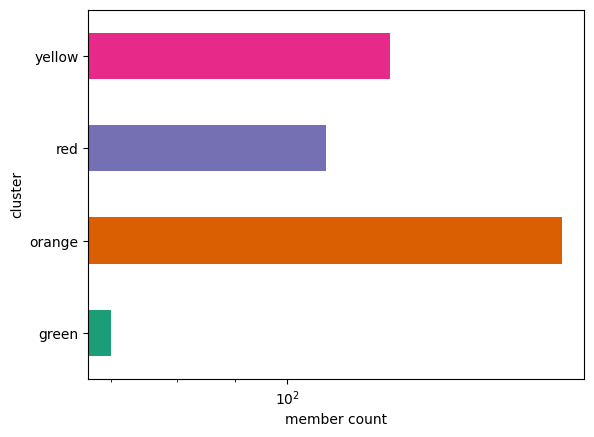

In [311]:
# add a color column to the main df
classification_df['color'] = classification_df['cluster'].map(color_map)

classification_df\
  .groupby('color')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="cluster", logx=True)

<Axes: xlabel='transformed_Percent!!RACE!!One race!!Asian!!Asian Indian', ylabel='transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'>

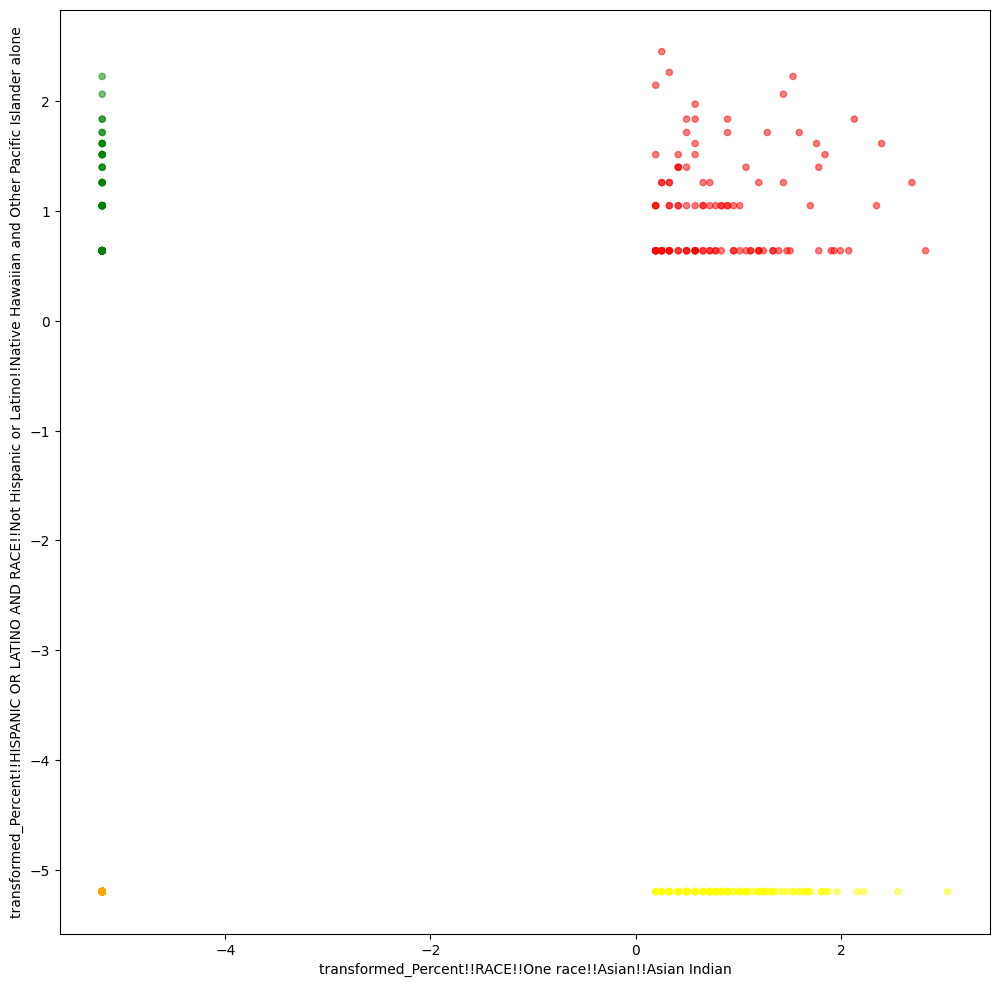

In [312]:
# color clusters by associated cluster
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

<Axes: xlabel='member count', ylabel='predicted region'>

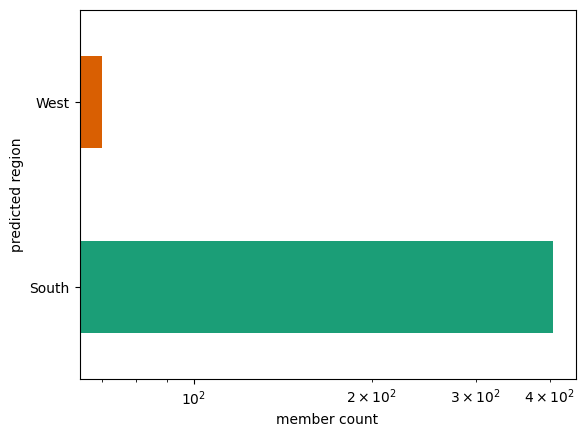

In [313]:
classification_df\
  .groupby('km_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="predicted region", logx=True)

<Axes: xlabel='transformed_Percent!!RACE!!One race!!Asian!!Asian Indian', ylabel='transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'>

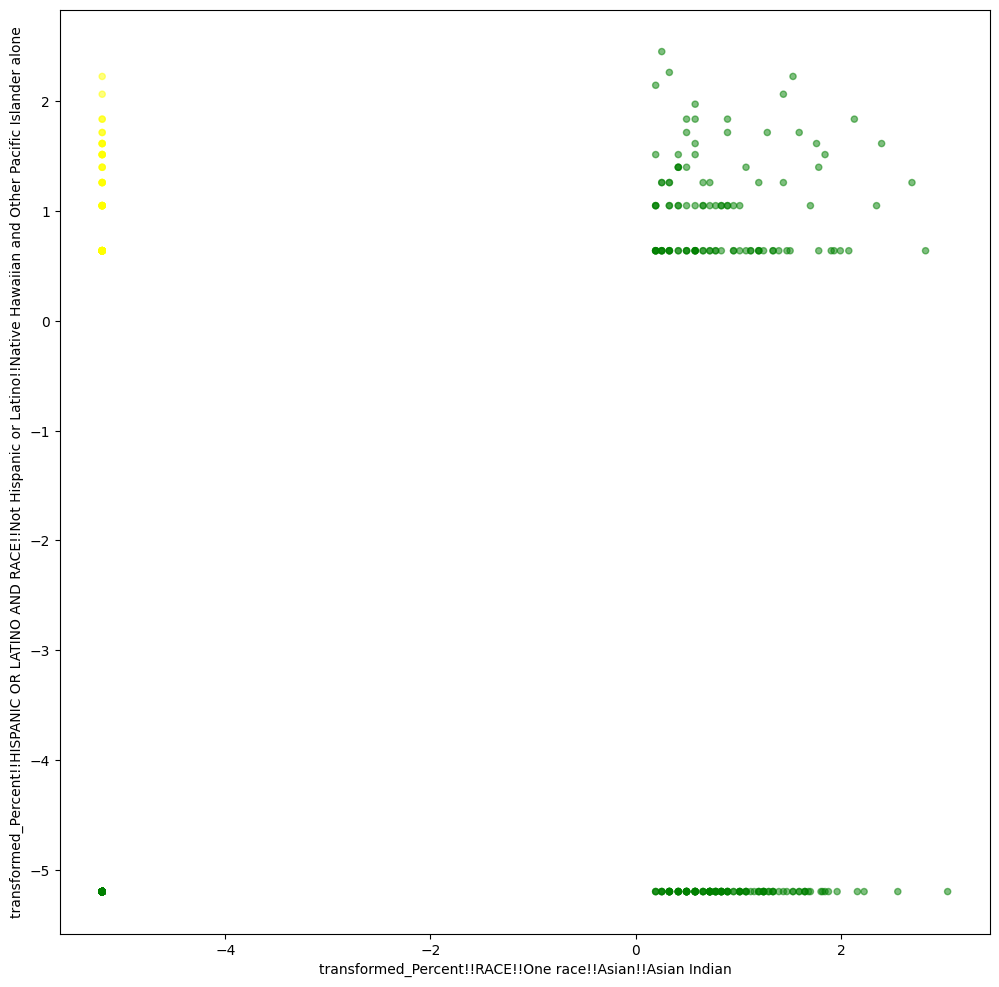

In [314]:
# add a color column to the main df
classification_df['color'] = classification_df['km_prediction'].map(color_map)

# color clusters by region majority class
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

###Naive Bayes

In [315]:
gnb_model = GaussianNB()

# predict classification_df['cluster'] from classification_df[review_features]
predictions = gnb_model\
                .fit(classification_df[review_features], county_hate_rates_df["region"])\
                .predict(classification_df[review_features])

classification_df["nb_prediction"] = predictions

classification_df["nb_prediction_name"] = pd.Series(predictions).map(region_name_map)

# get the silhouette score of the Naive Bayes classifier's predictions
gnb_silhouette_score = metrics.silhouette_score(classification_df[review_features], predictions)

In [316]:
print(gnb_silhouette_score)

0.3436537644332089


<Axes: xlabel='member count', ylabel='region'>

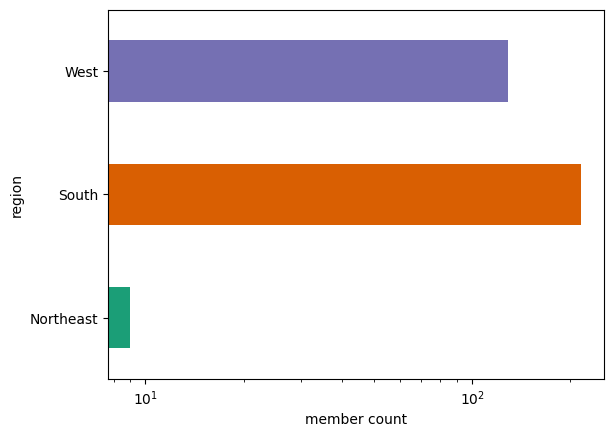

In [317]:
classification_df\
  .groupby('nb_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="region", logx=True)

Legend:
        South: Green
        West: Yellow
        Northeast: Red
        Midwest: Orange


<Axes: xlabel='transformed_Percent!!RACE!!One race!!Asian!!Asian Indian', ylabel='transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'>

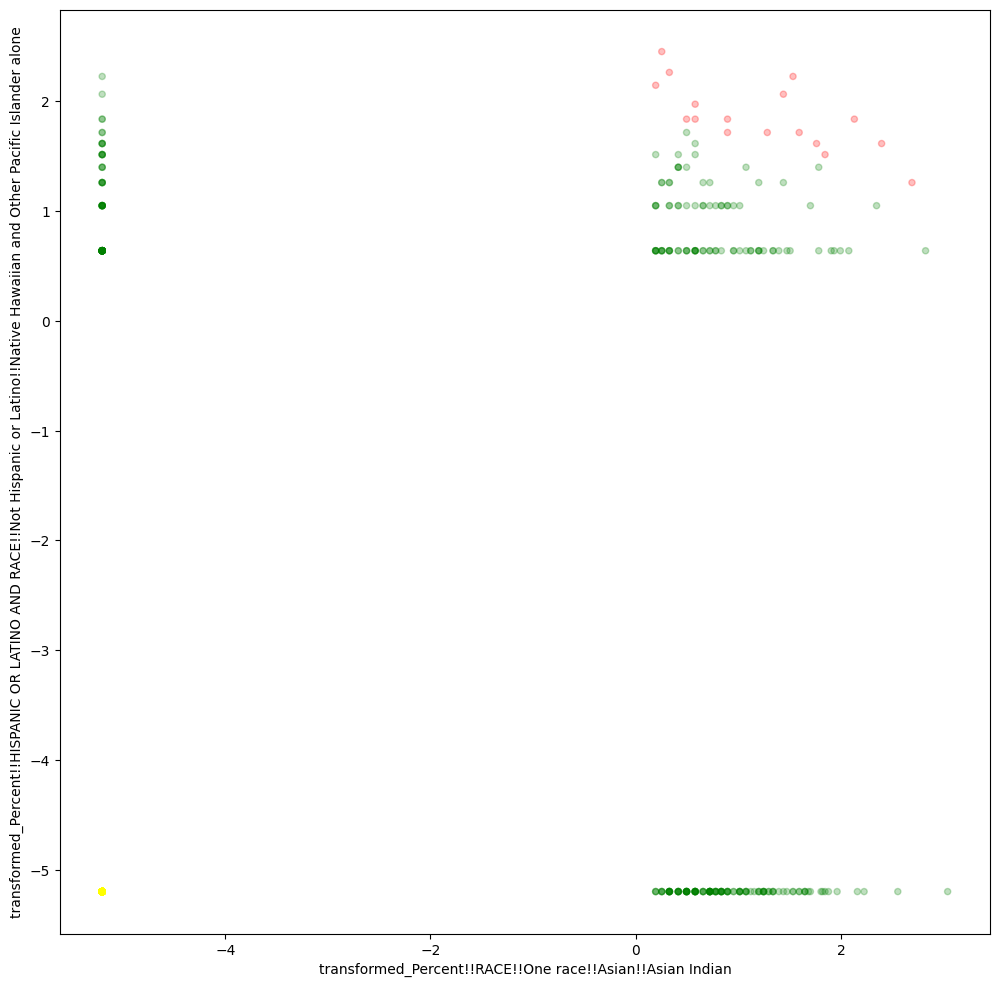

In [320]:
classification_df['color'] = classification_df['nb_prediction'].map(color_map)
print("Legend:\n\
        South: Green\n\
        West: Yellow\n\
        Northeast: Red\n\
        Midwest: Orange")

# plot the features under consideration with the colors determined by the naive bayes classifier
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.25,\
           figsize=(12, 12))

###Compare Clustering/Classification Models

In [321]:
print("K-Means Silhouette Score: " + str(best_clustering["silhouette_score"]))
print("Naive Bayes Silhouette Score: " + str(gnb_silhouette_score))

K-Means Silhouette Score: 0.7786296441943121
Naive Bayes Silhouette Score: 0.3436537644332089
